## 1. Import and Setup

In [1]:
import sys, os
sys.path.append(os.path.abspath("../src"))

# Torch & GNN
import torch
from torch_geometric.nn import GATConv

# Custom modules
from data_utils_temporal import load_and_preprocess_elliptic_temporal
from train_temporal import temporal_split
from model_gat import GATNet
from train_utils import set_seed, train_full, save_feature_experiment
from config import SEEDS

# Feature pipeline
from features.feature_config import FEATURE_CONFIGS
from features.feature_runner import apply_engineered_features
from features.feature_utils import prepare_graph_and_timestamps

print("✓ All modules imported successfully.")

✓ All modules imported successfully.


## 2. Load and Preprocess the Elliptic Dataset
This loads the data, maps transaction IDs to node indices, filters isolated nodes, and normalizes node features. Uses temporal splitting.


In [2]:
from normalization import normalize_base_features_only
from features.feature_pipeline import generate_all_features
from features.feature_utils import prepare_graph_and_timestamps
from data_utils_temporal import load_and_preprocess_elliptic_temporal
from train_temporal import temporal_split
from features.feature_config import FEATURE_CONFIGS
from train_utils import set_seed
from config import SEEDS
import torch
import os

# 1. Load PyG temporal data (with node_times)
data, node_times = load_and_preprocess_elliptic_temporal("../elliptic_bitcoin_dataset", normalize=False)
print(f"✓ Temporal PyG Data object loaded: {data}")

# 2. Prepare NetworkX graph + timestamps
G_nx, node_timestamps = prepare_graph_and_timestamps(
    edgelist_path="../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv",
    features_path="../elliptic_bitcoin_dataset/elliptic_txs_features.csv",
    num_nodes=data.num_nodes
)

print(f"✓ NetworkX Graph: {G_nx.number_of_nodes()} nodes, {G_nx.number_of_edges()} edges")
print(f"✓ Timestamps found for {sum(len(ts) > 0 for ts in node_timestamps)} nodes")

# 3. Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ABLATORS = {
    k: v for k, v in FEATURE_CONFIGS.items()
}
FEATURED_DATA = {}

# 4. Loop through ablations + seeds
for ablation_name, feature_flags in ABLATORS.items():
    print(f"\n== Config: {ablation_name} ==")
    for seed in SEEDS:
        print(f"→ Seed {seed}")
        set_seed(seed)

        # 4.1 Temporal split (train up to time step 35)
        train_idx, val_idx = temporal_split(data, node_times=node_times, train_until=35)

        # 4.2 Feature engineering
        data_exp = data.clone()
        X, feature_names = generate_all_features(data_exp, G_nx, node_timestamps, **feature_flags)
        data_exp.x = torch.tensor(X, dtype=torch.float)

        # Optional: monitor temporal feature stats
        temporal_names = {"temporal_lag", "component_size"}
        temporal_indices = [i for i, name in enumerate(feature_names) if name in temporal_names]
        if temporal_indices:
            print("→ Temporal features (raw)")
            print("  Means:", data_exp.x[:, temporal_indices].mean(0))
            print("  Stds :", data_exp.x[:, temporal_indices].std(0))

        # 4.3 Normalize base features only
        data_exp.x = normalize_base_features_only(data_exp.x, feature_names)

        # 4.4 Finalize
        data_exp = data_exp.to(device)
        FEATURED_DATA[(ablation_name, seed)] = {
            "data": data_exp,
            "train_idx": train_idx,
            "val_idx": val_idx,
            "feature_flags": feature_flags,
        }

        # 4.5 Save to disk
        save_dir = f"../data/GAT_temporal/{ablation_name}/seed_{seed}"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(data_exp, os.path.join(save_dir, "data_exp.pt"))
        torch.save(train_idx, os.path.join(save_dir, "train_idx.pt"))
        torch.save(val_idx, os.path.join(save_dir, "val_idx.pt"))
        print(f"✓ Saved to {save_dir}")
        print(f"✓ Final shape: {data_exp.x.shape}")


✓ Temporal PyG Data object loaded: Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])
Loaded directed graph with 203769 nodes and 234355 edges.
Graph type: <class 'networkx.classes.digraph.DiGraph'>
Features DataFrame shape: (203769, 167)
Number of features (excluding txId and time_step): 165
Timestamps found for 203769 out of 203769 nodes.
✓ Time step range: 1.0 to 49.0
✓ NetworkX Graph: 203769 nodes, 234355 edges
✓ Timestamps found for 203769 nodes

== Config: base ==
→ Seed 42
✓ Saved to ../data/GAT_temporal/base/seed_42
✓ Final shape: torch.Size([203769, 166])
→ Seed 123
✓ Saved to ../data/GAT_temporal/base/seed_123
✓ Final shape: torch.Size([203769, 166])
→ Seed 777
✓ Saved to ../data/GAT_temporal/base/seed_777
✓ Final shape: torch.Size([203769, 166])
→ Seed 2023
✓ Saved to ../data/GAT_temporal/base/seed_2023
✓ Final shape: torch.Size([203769, 166])
→ Seed 31415
✓ Saved to ../data/GAT_temporal/base/seed_31415
✓ Final shape: torch.Size([203769, 166])

== Config: base+structu

Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 507325.01it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal/seed_42
✓ Final shape: torch.Size([203769, 168])
→ Seed 123


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 501421.03it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal/seed_123
✓ Final shape: torch.Size([203769, 168])
→ Seed 777


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 524640.73it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal/seed_777
✓ Final shape: torch.Size([203769, 168])
→ Seed 2023


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 387764.02it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal/seed_2023
✓ Final shape: torch.Size([203769, 168])
→ Seed 31415


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 561567.80it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal/seed_31415
✓ Final shape: torch.Size([203769, 168])

== Config: base+basic_temporal+typology ==
→ Seed 42


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 456476.48it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal+typology/seed_42
✓ Final shape: torch.Size([203769, 170])
→ Seed 123


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 510614.21it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal+typology/seed_123
✓ Final shape: torch.Size([203769, 170])
→ Seed 777


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 575307.75it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal+typology/seed_777
✓ Final shape: torch.Size([203769, 170])
→ Seed 2023


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 455839.34it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal+typology/seed_2023
✓ Final shape: torch.Size([203769, 170])
→ Seed 31415


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 561091.48it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/base+basic_temporal+typology/seed_31415
✓ Final shape: torch.Size([203769, 170])

== Config: all ==
→ Seed 42


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 584620.60it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/all/seed_42
✓ Final shape: torch.Size([203769, 174])
→ Seed 123


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 566023.29it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/all/seed_123
✓ Final shape: torch.Size([203769, 174])
→ Seed 777


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 598453.73it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/all/seed_777
✓ Final shape: torch.Size([203769, 174])
→ Seed 2023


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 507504.25it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/all/seed_2023
✓ Final shape: torch.Size([203769, 174])
→ Seed 31415


Computing temporal features: 100%|██████████| 203769/203769 [00:00<00:00, 572253.85it/s]


→ Temporal features (raw)
  Means: tensor([25.1560])
  Stds : tensor([15.1722])
✓ Saved to ../data/GAT_temporal/all/seed_31415
✓ Final shape: torch.Size([203769, 174])


In [3]:
import torch
import os

ROOT_DIR = "../data/GAT_temporal"
BASE_DIM = 166
SEEDS = [42, 123, 777, 2023, 31415]

print("\n📊 ENGINEERED FEATURE INSPECTION (from disk)")

# Loop over ablation folders
for ablation_name in sorted(os.listdir(ROOT_DIR)):
    ablation_path = os.path.join(ROOT_DIR, ablation_name)
    if not os.path.isdir(ablation_path):
        continue

    for seed in SEEDS:
        seed_dir = f"seed_{seed}"
        data_path = os.path.join(ablation_path, seed_dir, "data_exp.pt")
        if not os.path.exists(data_path):
            print(f"⛔ Missing file: {data_path}")
            continue

        data = torch.load(data_path, map_location="cpu", weights_only=False)
        x = data.x

        if x.shape[1] <= BASE_DIM:
            print(f"\n {ablation_name} | Seed: {seed}")
            print(" No engineered features found.")
            continue

        engineered = x[:, BASE_DIM:]
        print(f"\n {ablation_name} | Seed: {seed}")
        print(f" Engineered feature count: {engineered.shape[1]}")

        means = engineered.mean(dim=0)
        stds = engineered.std(dim=0)

        for i in range(engineered.shape[1]):
            m = means[i].item()
            s = stds[i].item()
            sample_vals = engineered[:5, i].numpy()
            print(f"Feature {BASE_DIM + i:>3} | Mean: {m:8.4f} | Std: {s:8.4f} | Sample: {sample_vals}")



📊 ENGINEERED FEATURE INSPECTION (from disk)

 all | Seed: 42
 Engineered feature count: 8
Feature 166 | Mean:   1.1501 | Std:   3.9111 | Sample: [1. 0. 1. 1. 0.]
Feature 167 | Mean:   1.1501 | Std:   1.8947 | Sample: [  1.   3. 112.   0.  50.]
Feature 168 | Mean:   0.0000 | Std:   4.3634 | Sample: [   0.   -3. -111.    1.  -50.]
Feature 169 | Mean:   0.0138 | Std:   0.0973 | Sample: [0.         0.         0.00063211 0.         0.        ]
Feature 170 | Mean:   4.2315 | Std:   6.0100 | Sample: [ 0.6931467 14.914124   4.727387   0.        17.727533 ]
Feature 171 | Mean:   0.4457 | Std:   0.3437 | Sample: [0.49999976 0.         0.00884956 0.999999   0.        ]
Feature 172 | Mean:  25.1560 | Std:  15.1722 | Sample: [ 1. 43. 15. 48.  1.]
Feature 173 | Mean:   8.4067 | Std:   0.3653 | Sample: [7.991254  8.373092  7.8188324 8.97221   7.991254 ]

 all | Seed: 123
 Engineered feature count: 8
Feature 166 | Mean:   1.1501 | Std:   3.9111 | Sample: [1. 0. 1. 1. 0.]
Feature 167 | Mean:   1.1501 

## 3. Training Multiseed Models and Ablation

In [7]:
from model_gat import GATNet
from train_utils import train_full, save_feature_experiment
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SKIP_GAT_TEMPORAL = {"base+basic_temporal", "base+basic_temporal+typology", "base", "all"}
for (ablation_name, seed), bundle in FEATURED_DATA.items():
    if ablation_name in SKIP_GAT_TEMPORAL:
        print(f"Skipping already trained config: {ablation_name}, seed: {seed}")
        continue

    print(f"\n=== Training GAT (Temporal): {ablation_name} | Seed: {seed} ===")

    data_exp = bundle["data"]
    train_idx = bundle["train_idx"]
    val_idx = bundle["val_idx"]
    feature_flags = bundle["feature_flags"]

    # Initialize model
    model = GATNet(
        in_channels=data_exp.x.shape[1],
        hidden_channels=8,
        out_channels=2,
        heads=8,
        dropout=0.1
    ).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Train model
    model, *results = train_full(
        model=model,
        data=data_exp,
        train_idx=train_idx,
        val_idx=val_idx,
        optimizer=optimizer,
        num_epochs=300,
        patience=30
    )

    # Save logs and model
    output_dir = f"../model_features/temporal/GAT_ablation/{ablation_name}/seed_{seed}"
    os.makedirs(output_dir, exist_ok=True)

    save_feature_experiment(
        output_dir=output_dir,
        model=model,
        results=results,
        seed=seed,
        config={
            "model": "GAT",
            "ablation_name": ablation_name,
            "feature_flags": feature_flags,
            "feature_dim": data_exp.x.shape[1],
            "dropout": 0.1,
            "num_epochs": 300,
            "patience": 30,
            "lr": 0.001,
            "weight_decay": 5e-4
        },
        val_idx=val_idx
    )


Skipping already trained config: base, seed: 42
Skipping already trained config: base, seed: 123
Skipping already trained config: base, seed: 777
Skipping already trained config: base, seed: 2023
Skipping already trained config: base, seed: 31415

=== Training GAT (Temporal): base+structural | Seed: 42 ===
Epoch 001 | Loss: 1.9824 | Val Acc: 0.7135 | Val F1: 0.4593 | F1 Illicit: 0.8301
Epoch 002 | Loss: 1.8575 | Val Acc: 0.7369 | Val F1: 0.4793 | F1 Illicit: 0.8455
Epoch 003 | Loss: 1.1754 | Val Acc: 0.7454 | Val F1: 0.4957 | F1 Illicit: 0.8506
Epoch 004 | Loss: 1.1544 | Val Acc: 0.7440 | Val F1: 0.5052 | F1 Illicit: 0.8489
Epoch 005 | Loss: 1.6386 | Val Acc: 0.7448 | Val F1: 0.5150 | F1 Illicit: 0.8488
Epoch 006 | Loss: 1.2436 | Val Acc: 0.7424 | Val F1: 0.5171 | F1 Illicit: 0.8469
Epoch 007 | Loss: 0.5385 | Val Acc: 0.7447 | Val F1: 0.5215 | F1 Illicit: 0.8483
Epoch 008 | Loss: 0.6156 | Val Acc: 0.7434 | Val F1: 0.5234 | F1 Illicit: 0.8472
Epoch 009 | Loss: 0.6764 | Val Acc: 0.7470 |

## 4. Model Evaluation

In [2]:
import os
import json
import torch

base_dir = "../model_features/temporal/GAT_ablation"
data_dir = "../data/GAT_temporal"
seeds = [42, 123, 777, 2023, 31415]

for ablation in sorted(os.listdir(base_dir)):
    ablation_model_path = os.path.join(base_dir, ablation)
    ablation_data_path = os.path.join(data_dir, ablation)

    if not os.path.isdir(ablation_model_path):
        continue

    print(f"\n→ Processing ablation: {ablation}")

    for seed in seeds:
        seed_dir = f"seed_{seed}"
        config_path = os.path.join(ablation_model_path, seed_dir, "config.json")
        model_path = os.path.join(ablation_model_path, seed_dir, "model.pth")
        data_path = os.path.join(ablation_data_path, seed_dir, "data_exp.pt")

        if not all(os.path.exists(p) for p in [config_path, model_path, data_path]):
            continue

        # Load existing config
        with open(config_path, "r") as f:
            config = json.load(f)

        updated = False

        # Load data to recover feature_dim
        data = torch.load(data_path, map_location="cpu", weights_only=False)
        feature_dim = data.x.shape[1]
        if config.get("feature_dim") != feature_dim:
            config["feature_dim"] = feature_dim
            updated = True

        # Patch GAT-only fields
        if config.get("model") == "GAT":
            state_dict = torch.load(model_path, map_location="cpu")

            if "gat1.lin.weight" in state_dict:
                total_hidden_dim = state_dict["gat1.lin.weight"].shape[0]  # = heads * hidden_channels
                heads = config.get("heads", 8)
                hidden_channels = total_hidden_dim // heads

                if config.get("hidden_channels") != hidden_channels:
                    config["hidden_channels"] = hidden_channels
                    updated = True
                if config.get("heads") != heads:
                    config["heads"] = heads
                    updated = True
                if config.get("out_channels") != 2:
                    config["out_channels"] = 2
                    updated = True
            else:
                print(f"[!] Warning: gat1.lin.weight not found in {model_path}")
                continue

        if updated:
            with open(config_path, "w") as f:
                json.dump(config, f, indent=4)
            print(f"✓ Patched config for {ablation} / seed {seed}")
        else:
            print(f"✓ Already complete: {ablation} / seed {seed}")



→ Processing ablation: all
✓ Patched config for all / seed 42
✓ Patched config for all / seed 123
✓ Patched config for all / seed 777
✓ Patched config for all / seed 2023
✓ Patched config for all / seed 31415

→ Processing ablation: base
✓ Patched config for base / seed 42
✓ Patched config for base / seed 123
✓ Patched config for base / seed 777
✓ Patched config for base / seed 2023
✓ Patched config for base / seed 31415

→ Processing ablation: base+basic_temporal
✓ Patched config for base+basic_temporal / seed 42
✓ Patched config for base+basic_temporal / seed 123
✓ Patched config for base+basic_temporal / seed 777
✓ Patched config for base+basic_temporal / seed 2023
✓ Patched config for base+basic_temporal / seed 31415

→ Processing ablation: base+basic_temporal+typology
✓ Patched config for base+basic_temporal+typology / seed 42
✓ Patched config for base+basic_temporal+typology / seed 123
✓ Patched config for base+basic_temporal+typology / seed 777
✓ Patched config for base+basic_t


→ Evaluating ablation: all

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9567  0.0021  0.9567 ± 0.0021
1    val_f1_macro  0.7708  0.0120  0.7708 ± 0.0120
2  val_f1_illicit  0.9772  0.0011  0.9772 ± 0.0011



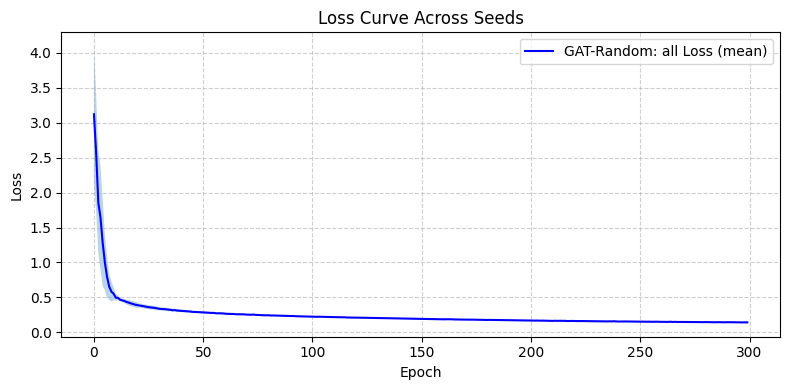

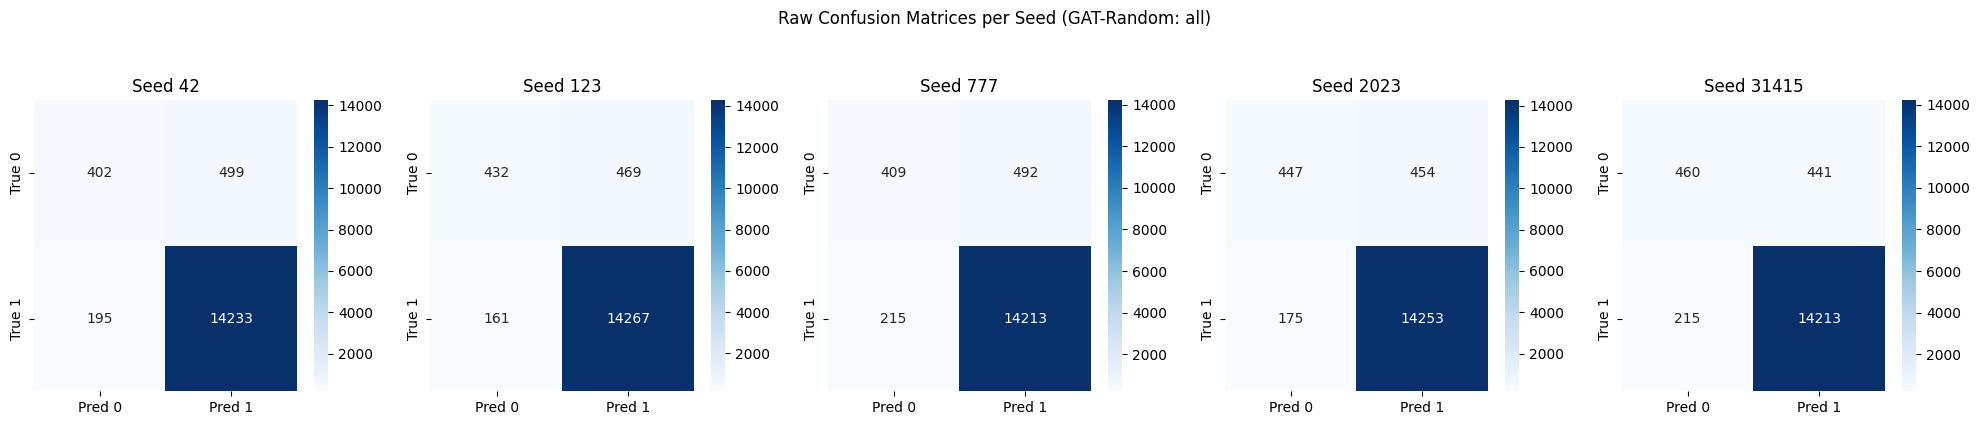

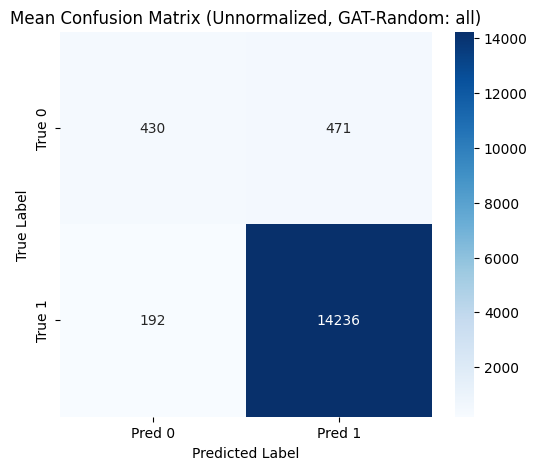

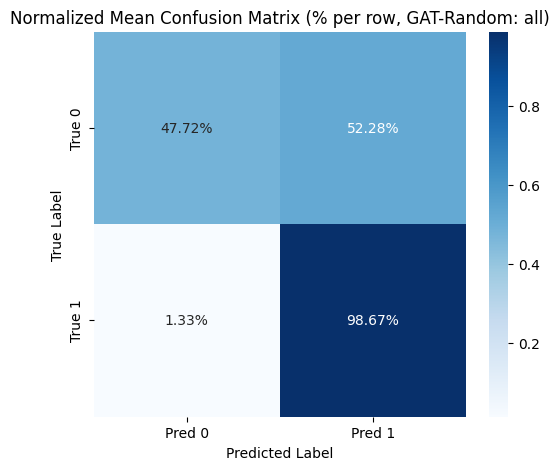

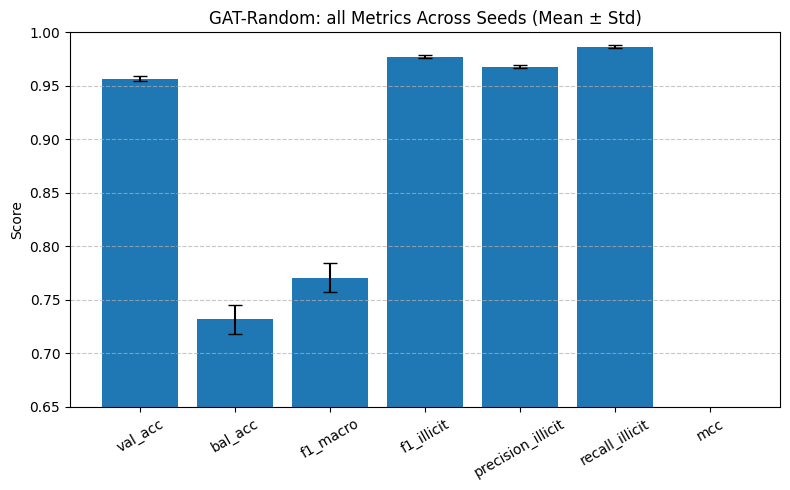

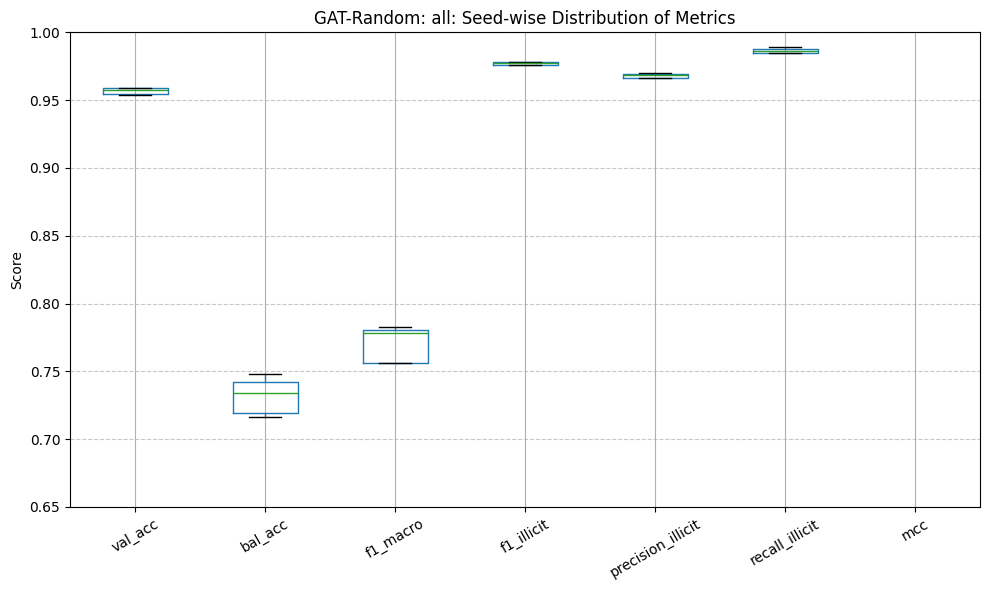

,Metric,Mean,Std,Formatted
0,val_acc,0.9567,0.0024,0.9567 ± 0.0024
1,bal_acc,0.7320,0.0137,0.7320 ± 0.0137
2,f1_macro,0.7708,0.0134,0.7708 ± 0.0134
3,f1_illicit,0.9772,0.0012,0.9772 ± 0.0012
4,precision_illicit,0.9680,0.0016,0.9680 ± 0.0016
5,recall_illicit,0.9867,0.0017,0.9867 ± 0.0017
6,mcc,0.5530,0.0264,0.5530 ± 0.0264



Legit (0) Metrics:
precision: 0.6915 ± 0.0277
recall: 0.4772 ± 0.0244
f1-score: 0.5644 ± 0.0229

Illicit (1) Metrics:
precision: 0.9680 ± 0.0015
recall: 0.9867 ± 0.0015
f1-score: 0.9772 ± 0.0011


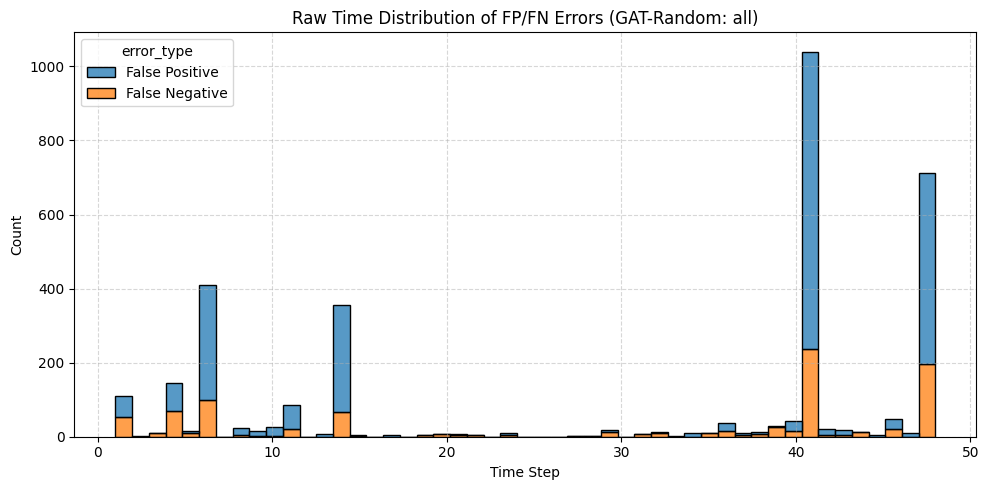

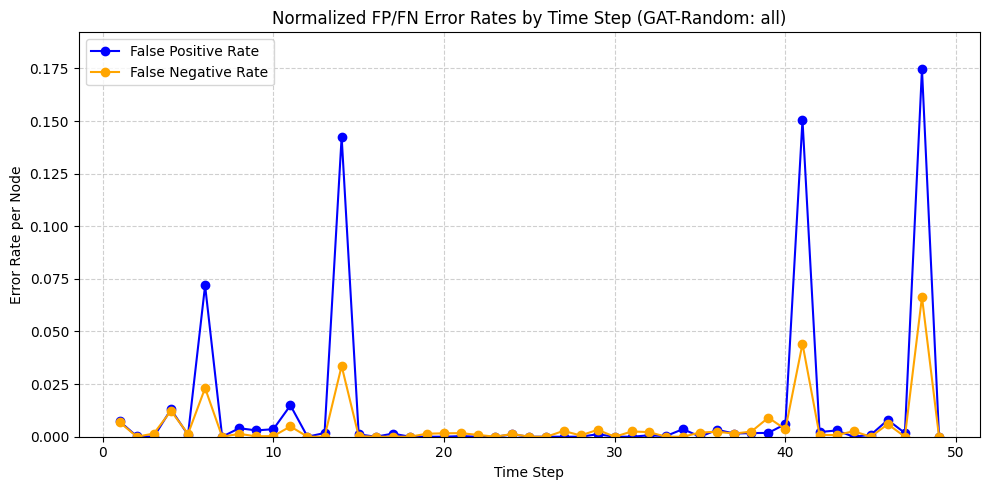


→ Evaluating ablation: base

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9543  0.0055  0.9543 ± 0.0055
1    val_f1_macro  0.7615  0.0275  0.7615 ± 0.0275
2  val_f1_illicit  0.9759  0.0029  0.9759 ± 0.0029



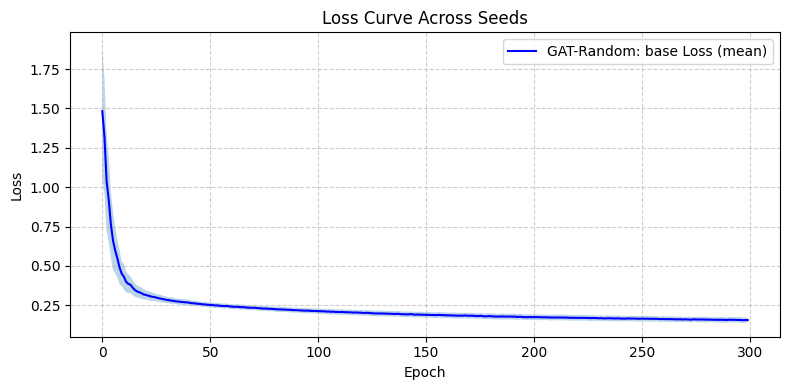

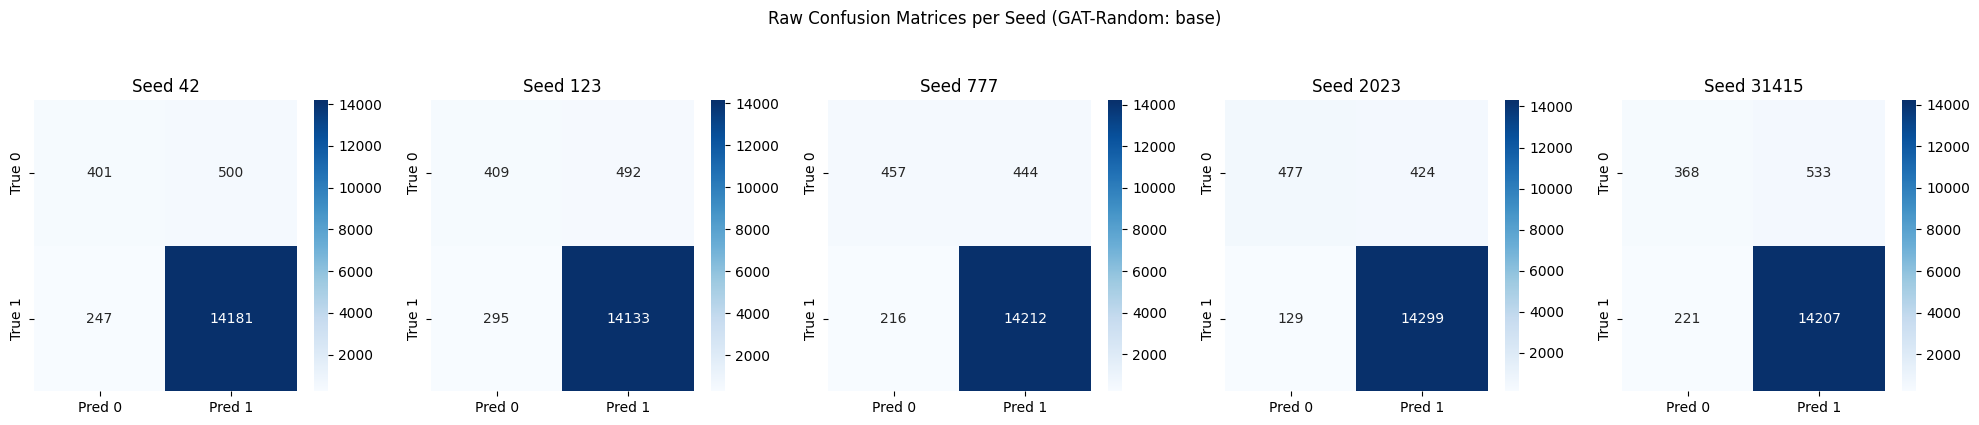

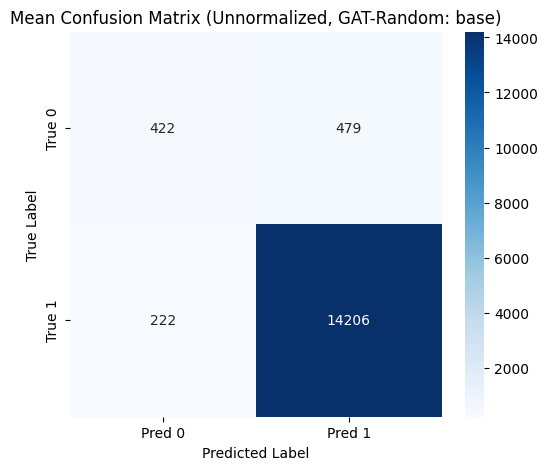

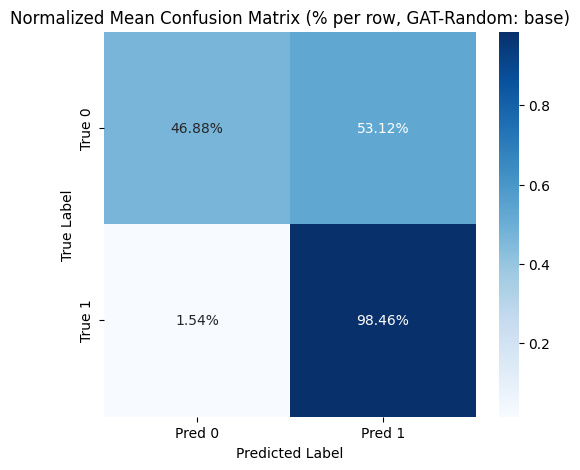

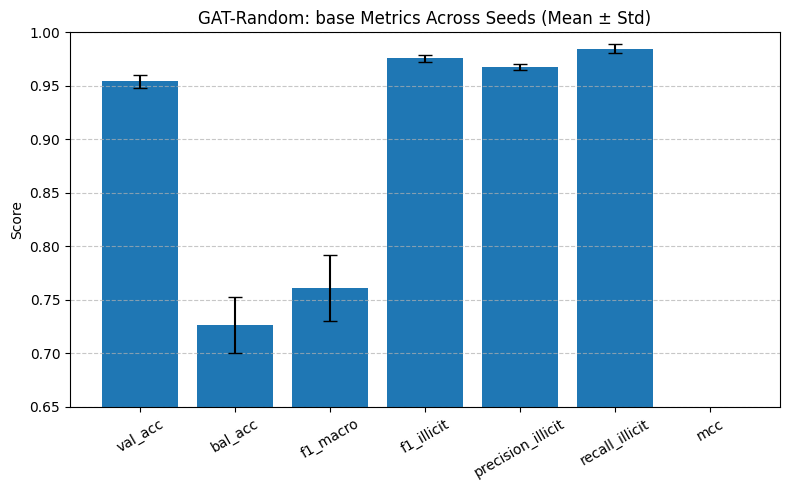

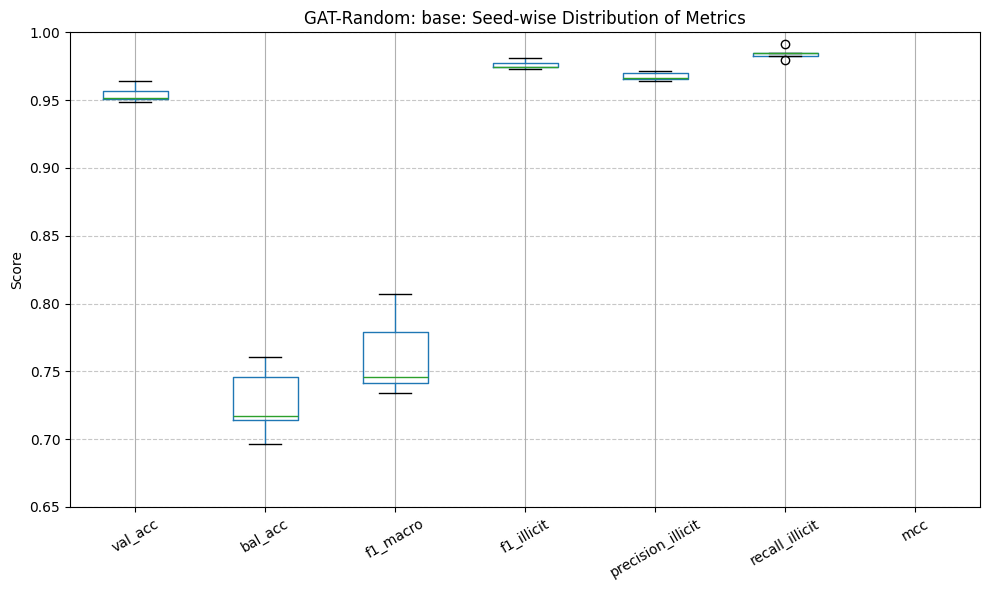

,Metric,Mean,Std,Formatted
0,val_acc,0.9543,0.0062,0.9543 ± 0.0062
1,bal_acc,0.7267,0.0258,0.7267 ± 0.0258
2,f1_macro,0.7615,0.0307,0.7615 ± 0.0307
3,f1_illicit,0.9759,0.0033,0.9759 ± 0.0033
4,precision_illicit,0.9674,0.0030,0.9674 ± 0.0030
5,recall_illicit,0.9846,0.0042,0.9846 ± 0.0042
6,mcc,0.5323,0.0632,0.5323 ± 0.0632



Legit (0) Metrics:
precision: 0.6582 ± 0.0717
recall: 0.4688 ± 0.0438
f1-score: 0.5470 ± 0.0522

Illicit (1) Metrics:
precision: 0.9674 ± 0.0027
recall: 0.9846 ± 0.0038
f1-score: 0.9759 ± 0.0029


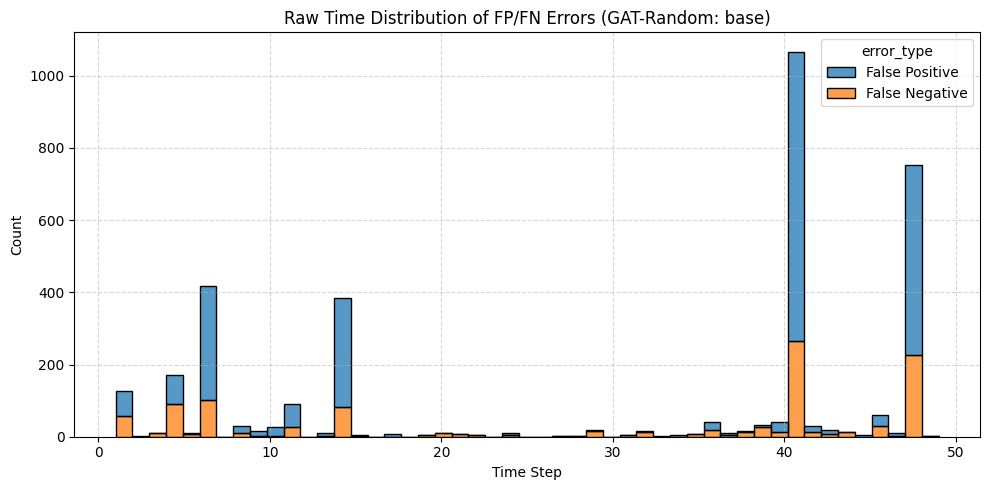

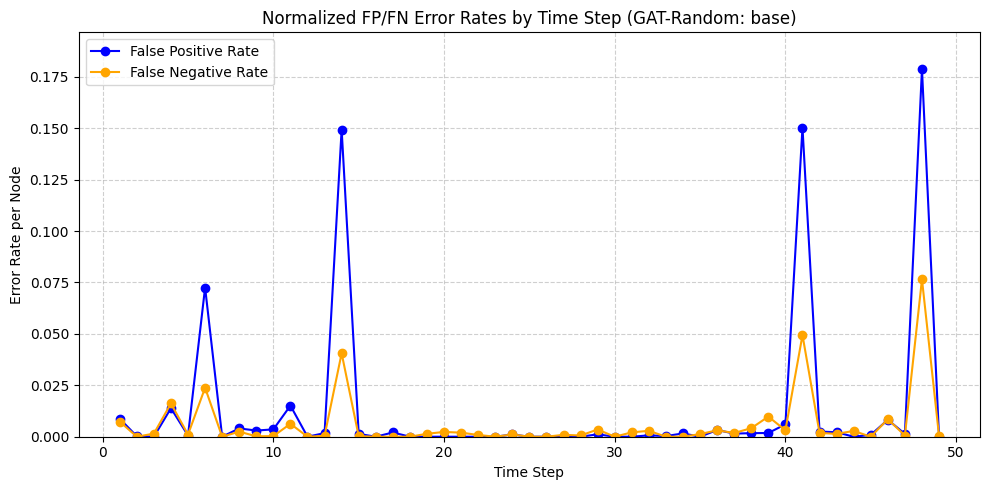


→ Evaluating ablation: base+basic_temporal

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9012  0.0669  0.9012 ± 0.0669
1    val_f1_macro  0.6849  0.0902  0.6849 ± 0.0902
2  val_f1_illicit  0.9450  0.0390  0.9450 ± 0.0390



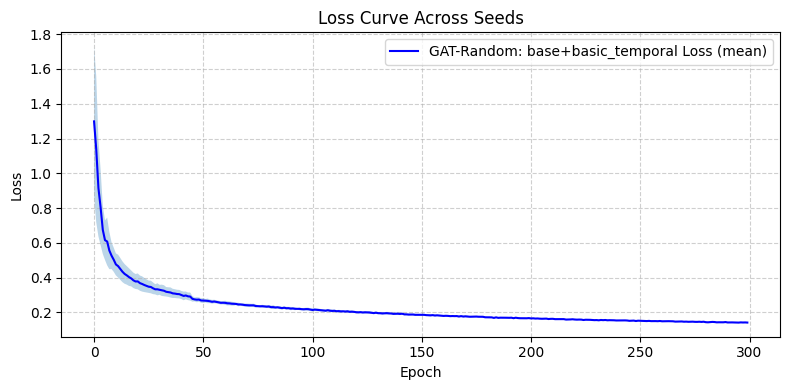

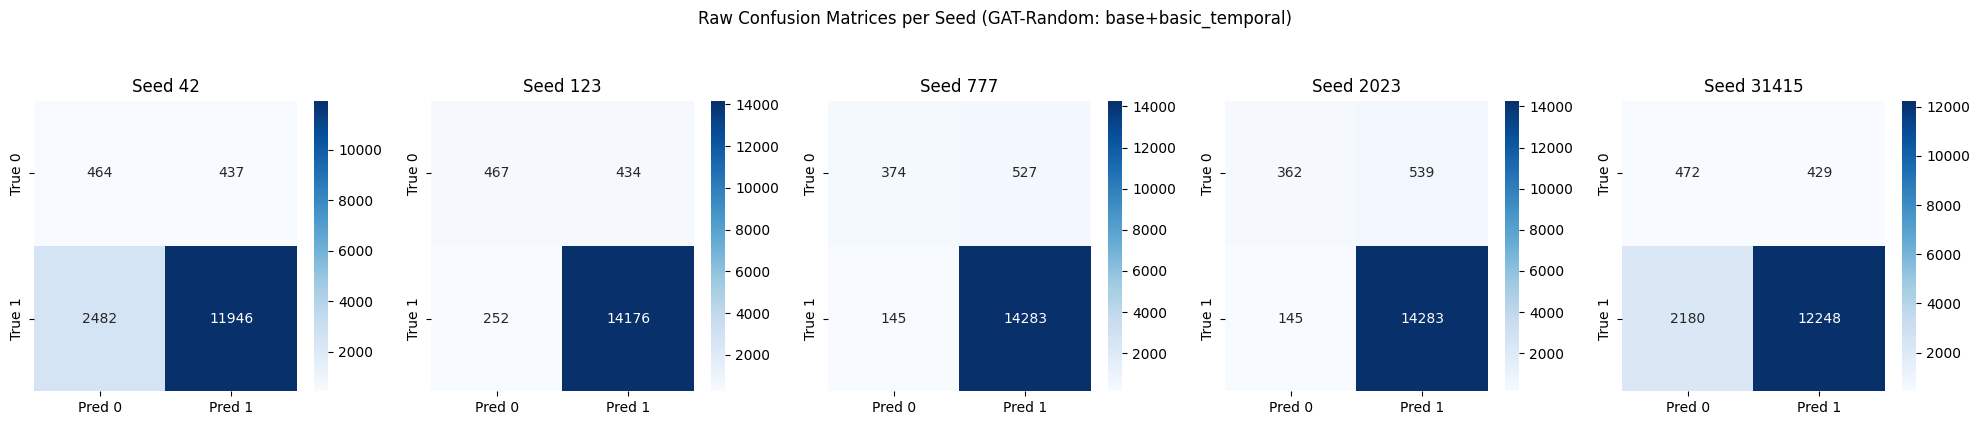

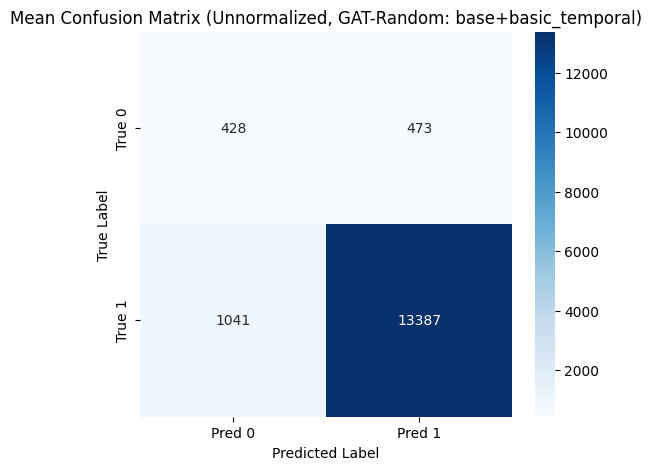

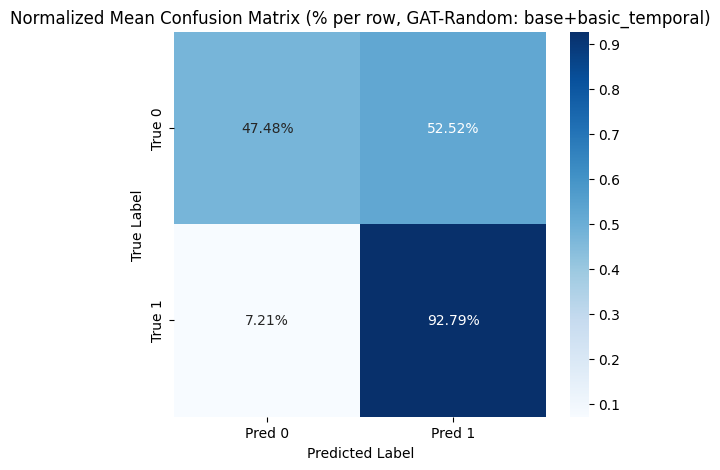

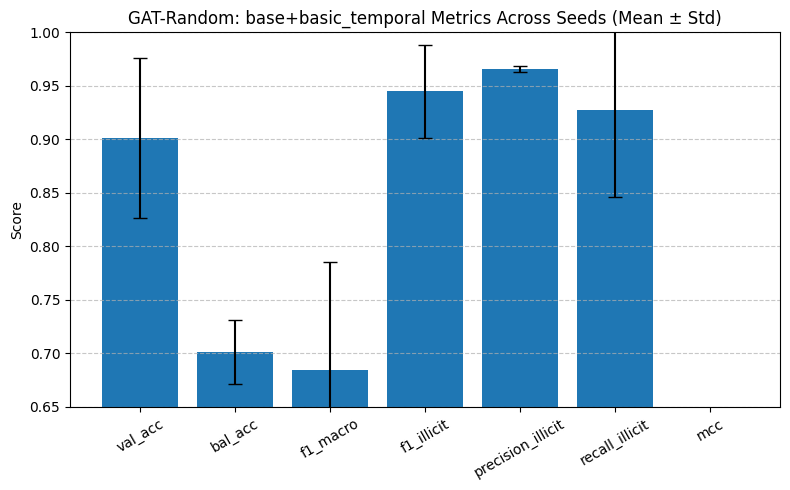

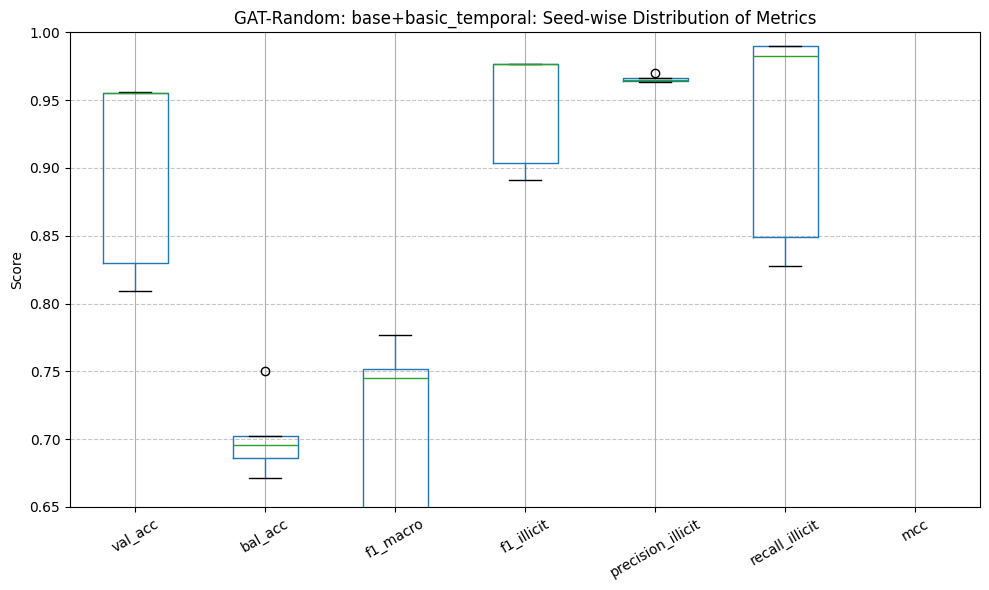

,Metric,Mean,Std,Formatted
0,val_acc,0.9012,0.0748,0.9012 ± 0.0748
1,bal_acc,0.7013,0.0298,0.7013 ± 0.0298
2,f1_macro,0.6849,0.1008,0.6849 ± 0.1008
3,f1_illicit,0.9450,0.0436,0.9450 ± 0.0436
4,precision_illicit,0.9658,0.0027,0.9658 ± 0.0027
5,recall_illicit,0.9279,0.0820,0.9279 ± 0.0820
6,mcc,0.4071,0.1734,0.4071 ± 0.1734



Legit (0) Metrics:
precision: 0.4839 ± 0.2594
recall: 0.4748 ± 0.0544
f1-score: 0.4249 ± 0.1417

Illicit (1) Metrics:
precision: 0.9658 ± 0.0024
recall: 0.9279 ± 0.0734
f1-score: 0.9450 ± 0.0390


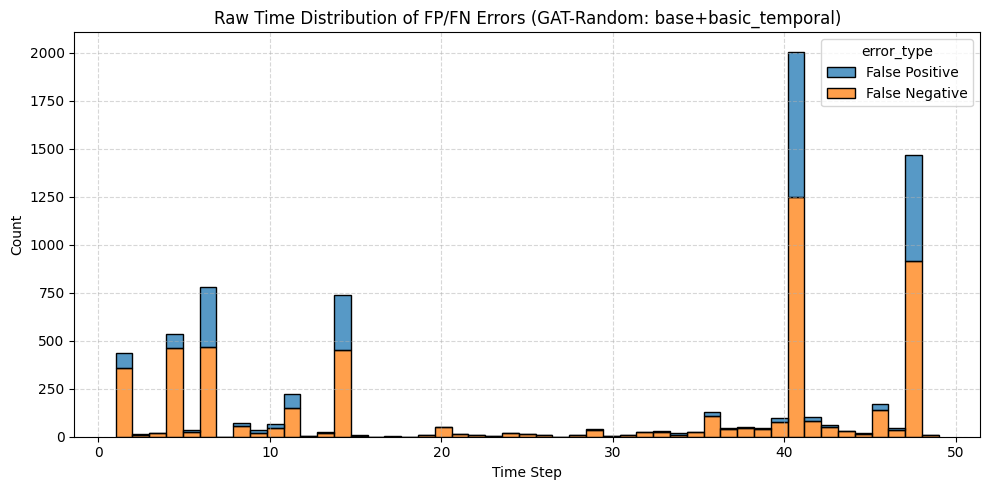

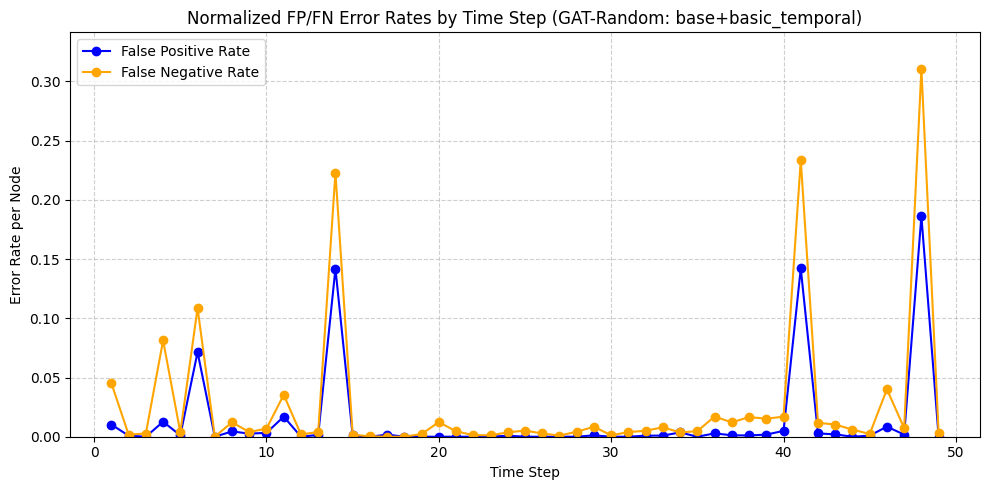


→ Evaluating ablation: base+basic_temporal+typology

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9568  0.0034  0.9568 ± 0.0034
1    val_f1_macro  0.7677  0.0165  0.7677 ± 0.0165
2  val_f1_illicit  0.9773  0.0018  0.9773 ± 0.0018



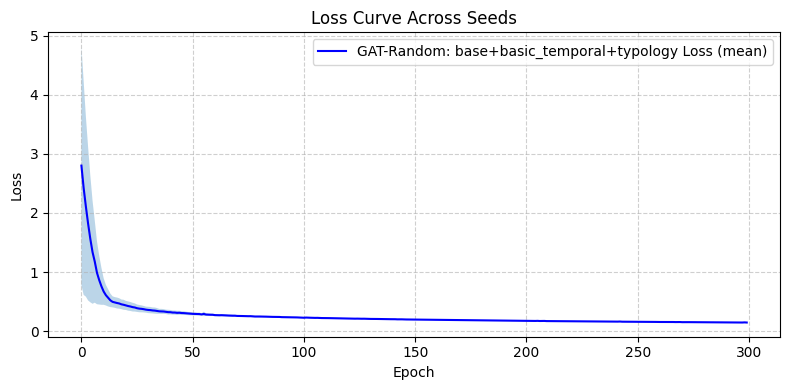

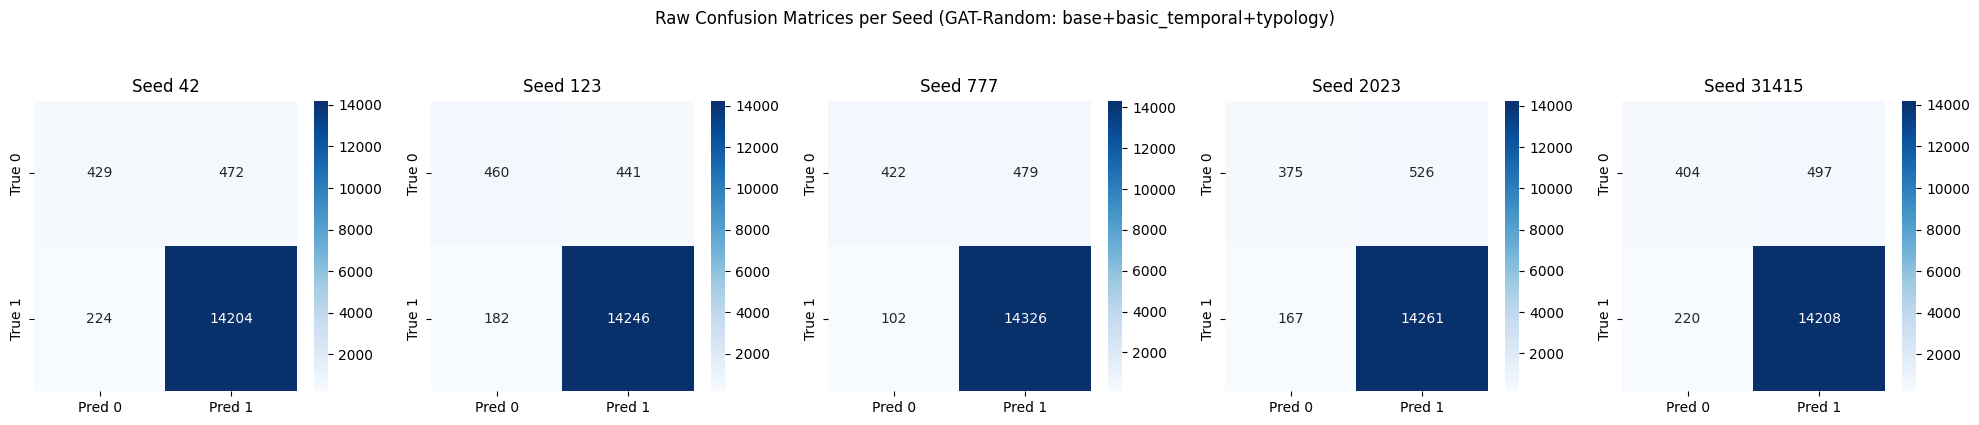

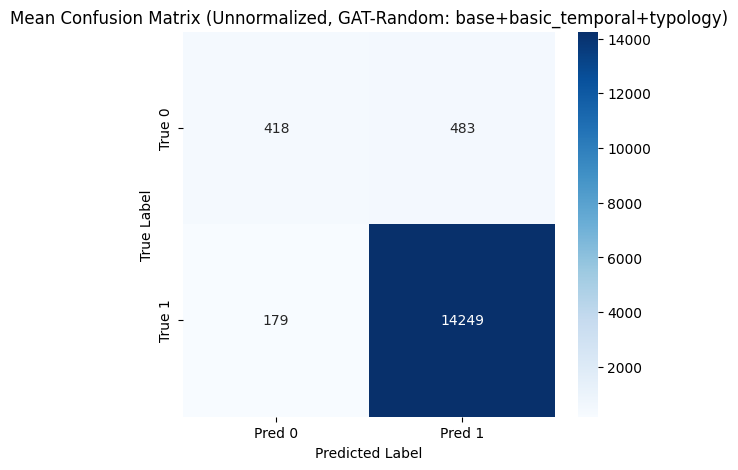

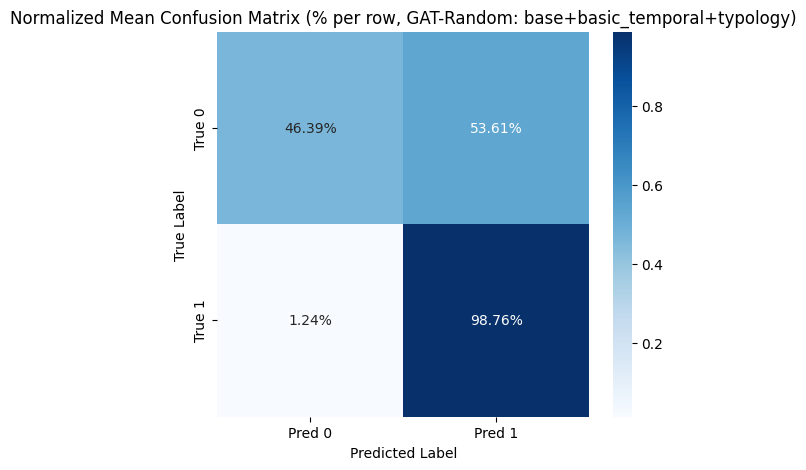

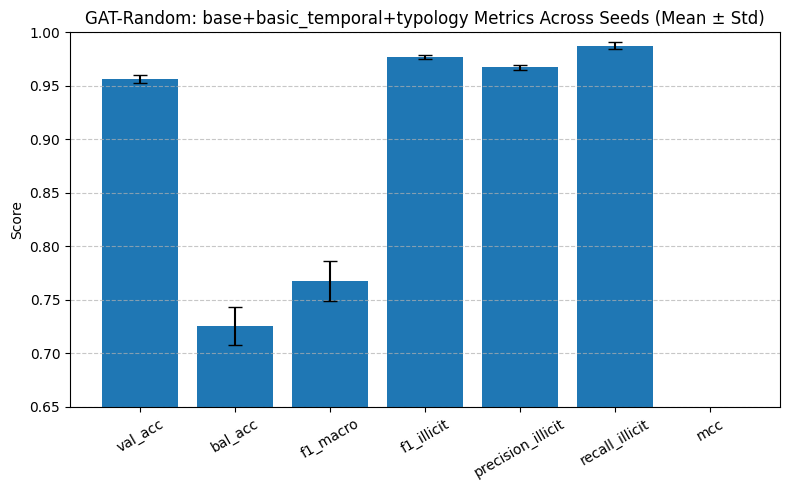

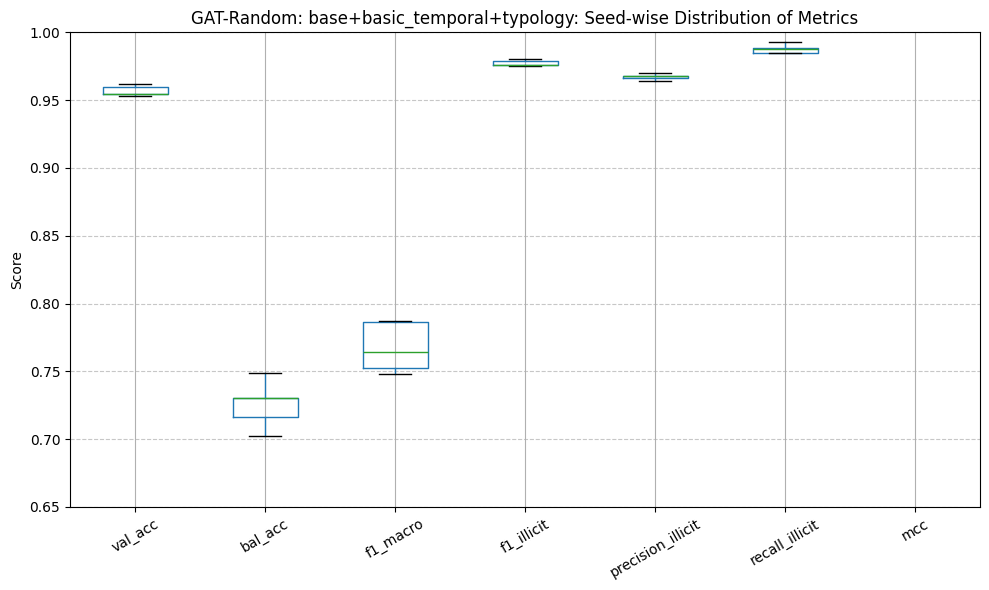

,Metric,Mean,Std,Formatted
0,val_acc,0.9568,0.0038,0.9568 ± 0.0038
1,bal_acc,0.7258,0.0174,0.7258 ± 0.0174
2,f1_macro,0.7677,0.0184,0.7677 ± 0.0184
3,f1_illicit,0.9773,0.0020,0.9773 ± 0.0020
4,precision_illicit,0.9672,0.0021,0.9672 ± 0.0021
5,recall_illicit,0.9876,0.0034,0.9876 ± 0.0034
6,mcc,0.5498,0.0387,0.5498 ± 0.0387



Legit (0) Metrics:
precision: 0.7036 ± 0.0565
recall: 0.4639 ± 0.0312
f1-score: 0.5580 ± 0.0314

Illicit (1) Metrics:
precision: 0.9672 ± 0.0018
recall: 0.9876 ± 0.0031
f1-score: 0.9773 ± 0.0018


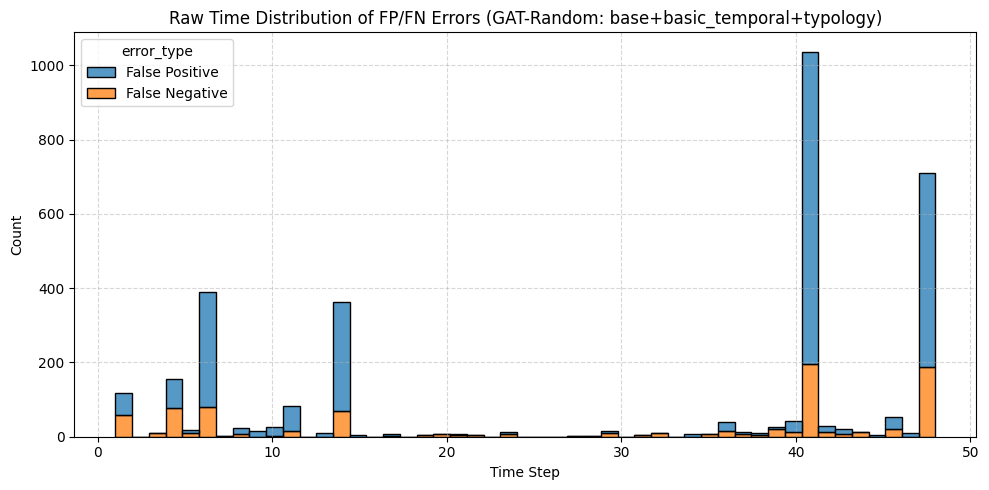

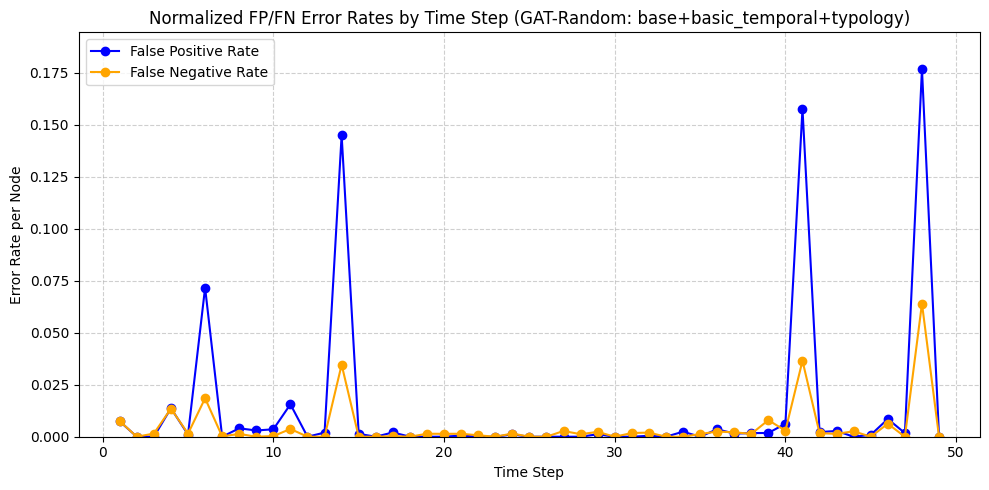


→ Evaluating ablation: base+structural

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9565  0.0043  0.9565 ± 0.0043
1    val_f1_macro  0.7870  0.0131  0.7870 ± 0.0131
2  val_f1_illicit  0.9770  0.0023  0.9770 ± 0.0023



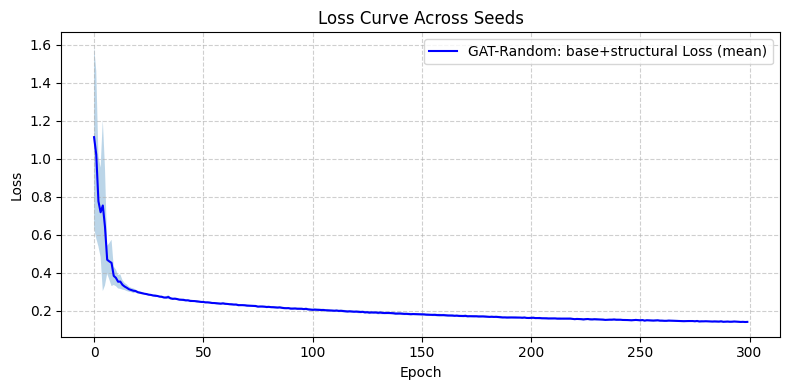

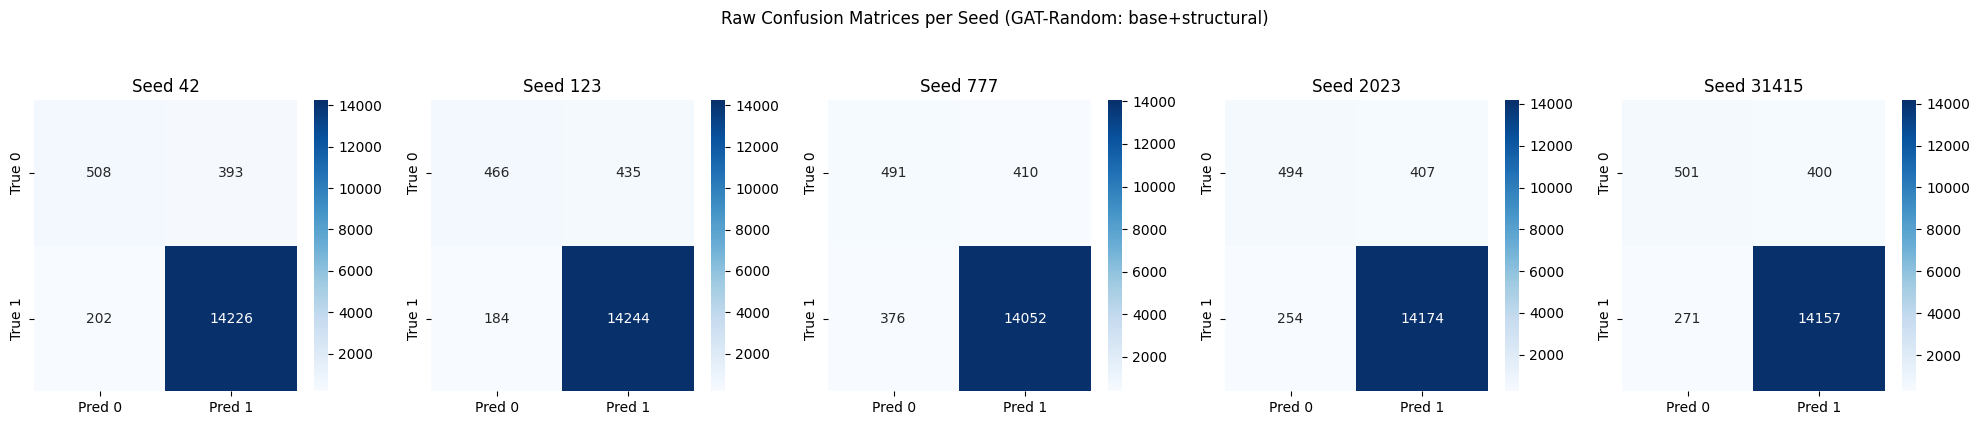

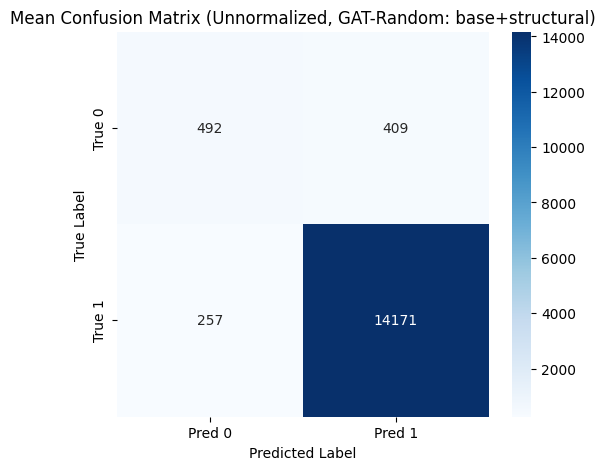

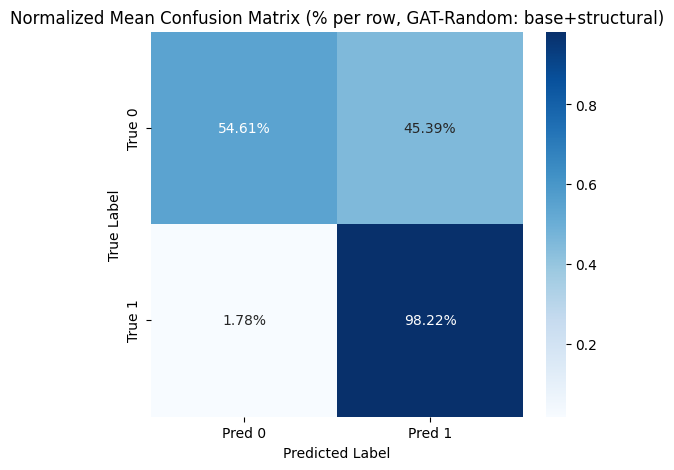

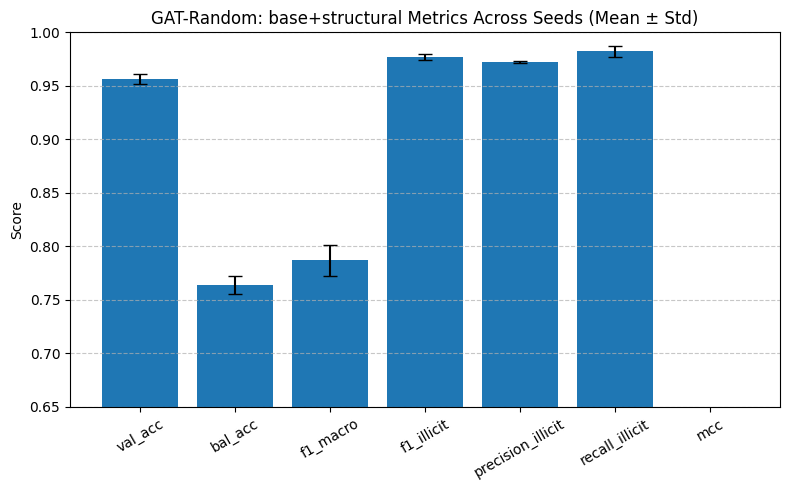

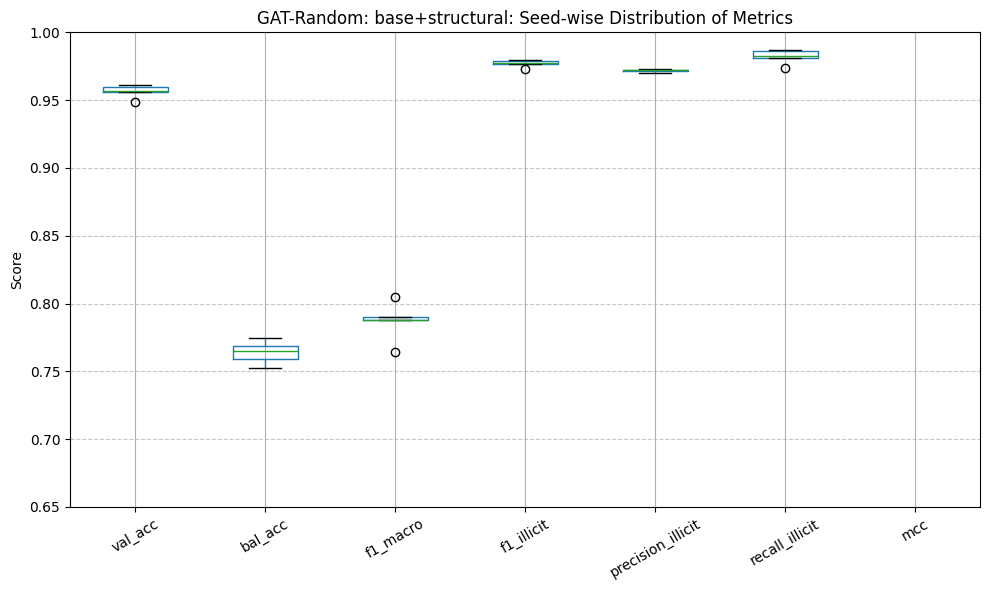

,Metric,Mean,Std,Formatted
0,val_acc,0.9565,0.0048,0.9565 ± 0.0048
1,bal_acc,0.7641,0.0087,0.7641 ± 0.0087
2,f1_macro,0.7870,0.0147,0.7870 ± 0.0147
3,f1_illicit,0.9770,0.0026,0.9770 ± 0.0026
4,precision_illicit,0.9719,0.0010,0.9719 ± 0.0010
5,recall_illicit,0.9822,0.0052,0.9822 ± 0.0052
6,mcc,0.5779,0.0315,0.5779 ± 0.0315



Legit (0) Metrics:
precision: 0.6616 ± 0.0551
recall: 0.5461 ± 0.0158
f1-score: 0.5970 ± 0.0240

Illicit (1) Metrics:
precision: 0.9719 ± 0.0009
recall: 0.9822 ± 0.0047
f1-score: 0.9770 ± 0.0023


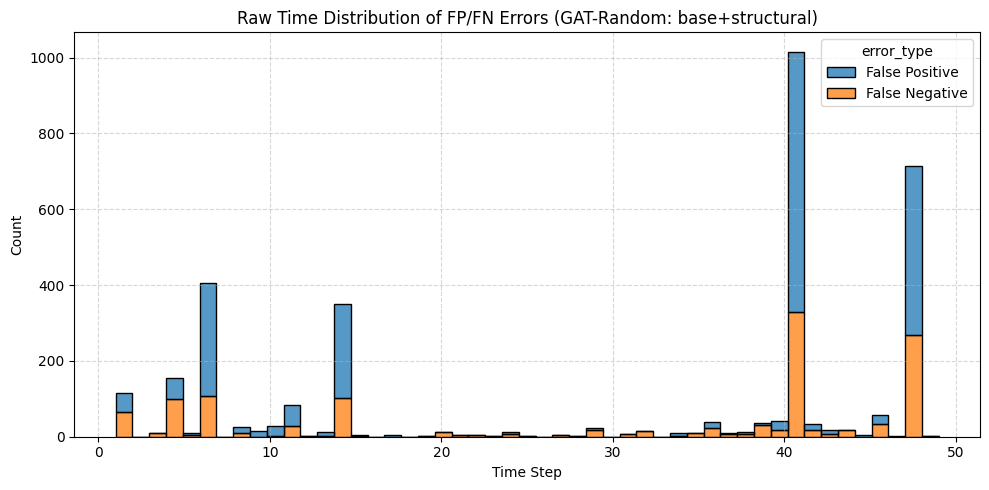

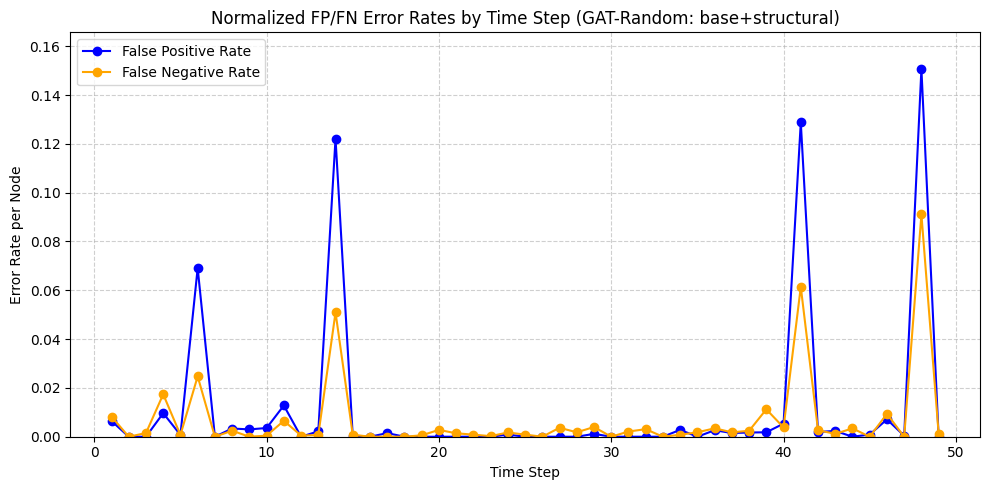


→ Evaluating ablation: base+structural+typology

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9546  0.0027  0.9546 ± 0.0027
1    val_f1_macro  0.7675  0.0166  0.7675 ± 0.0166
2  val_f1_illicit  0.9760  0.0014  0.9760 ± 0.0014



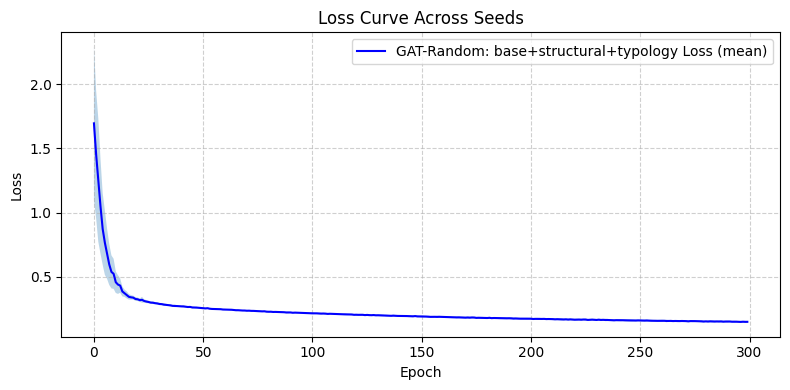

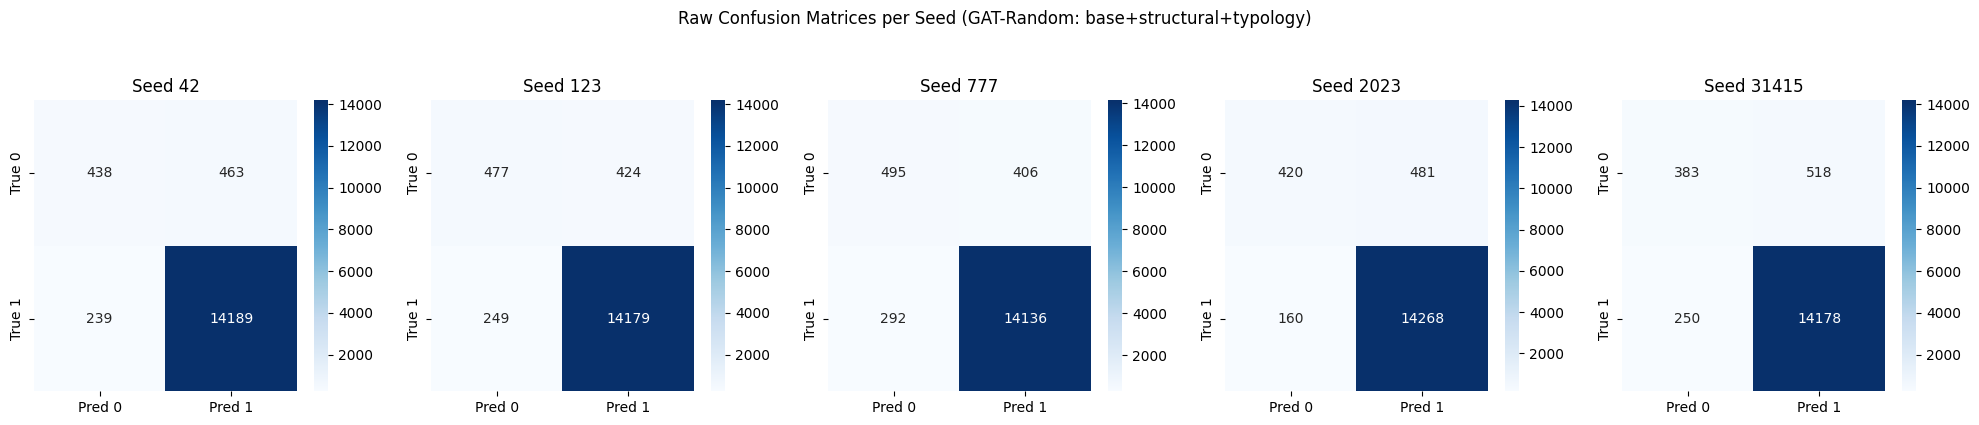

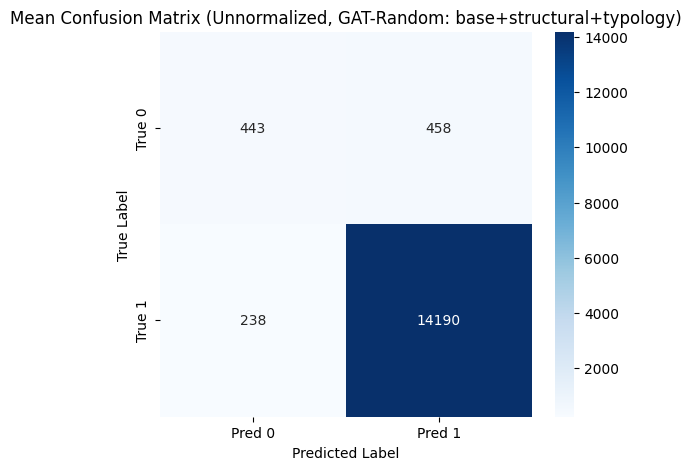

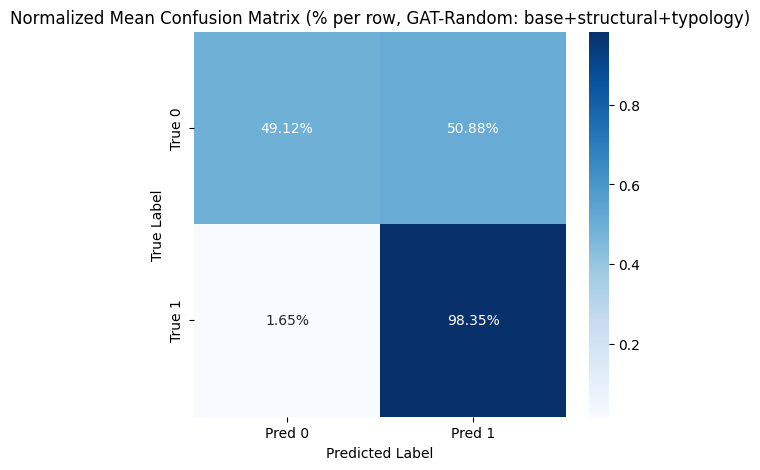

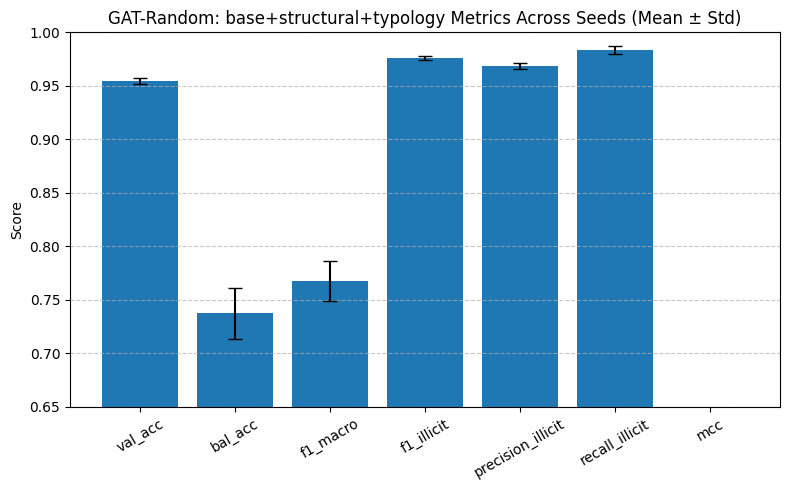

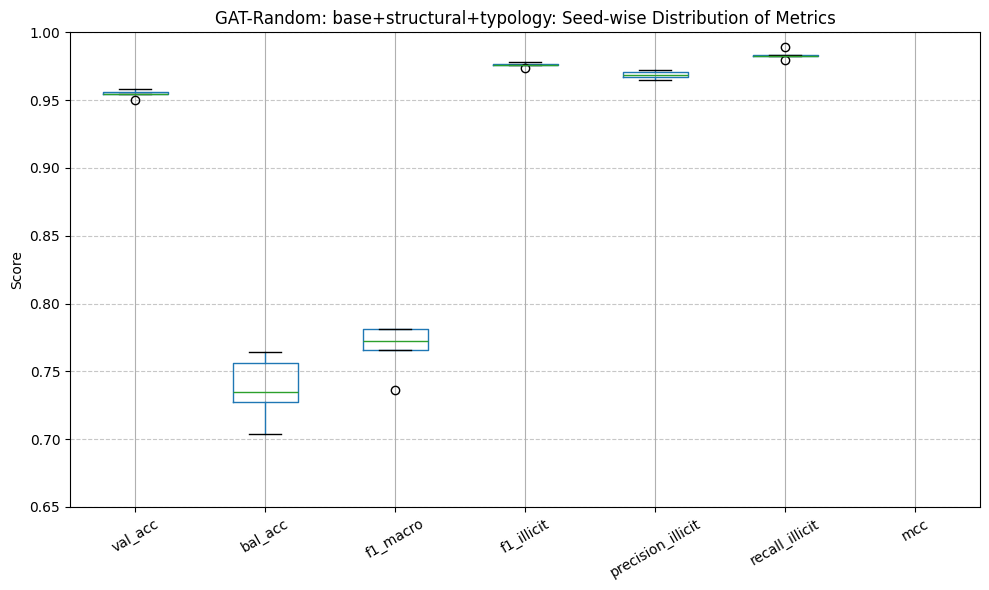

,Metric,Mean,Std,Formatted
0,val_acc,0.9546,0.0031,0.9546 ± 0.0031
1,bal_acc,0.7374,0.0241,0.7374 ± 0.0241
2,f1_macro,0.7675,0.0186,0.7675 ± 0.0186
3,f1_illicit,0.9760,0.0016,0.9760 ± 0.0016
4,precision_illicit,0.9687,0.0029,0.9687 ± 0.0029
5,recall_illicit,0.9835,0.0033,0.9835 ± 0.0033
6,mcc,0.5423,0.0357,0.5423 ± 0.0357



Legit (0) Metrics:
precision: 0.6524 ± 0.0400
recall: 0.4912 ± 0.0444
f1-score: 0.5589 ± 0.0321

Illicit (1) Metrics:
precision: 0.9687 ± 0.0026
recall: 0.9835 ± 0.0030
f1-score: 0.9760 ± 0.0014


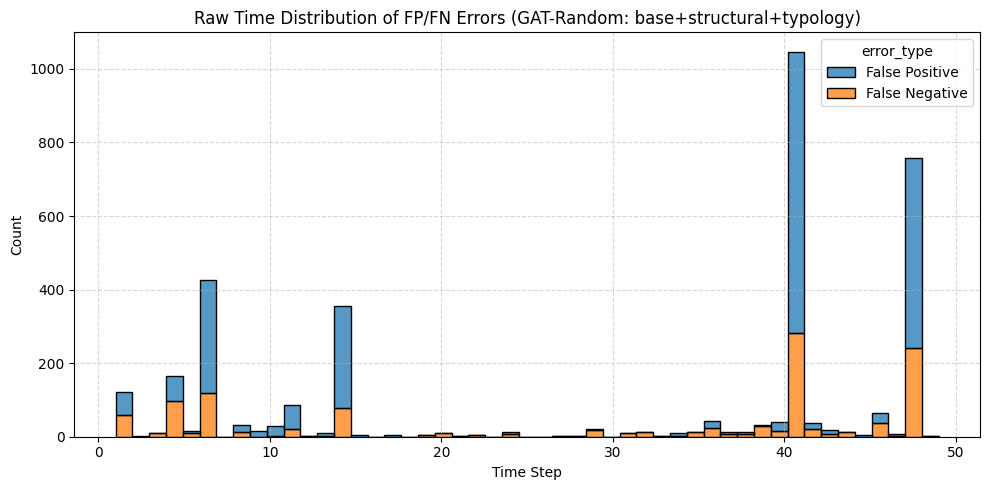

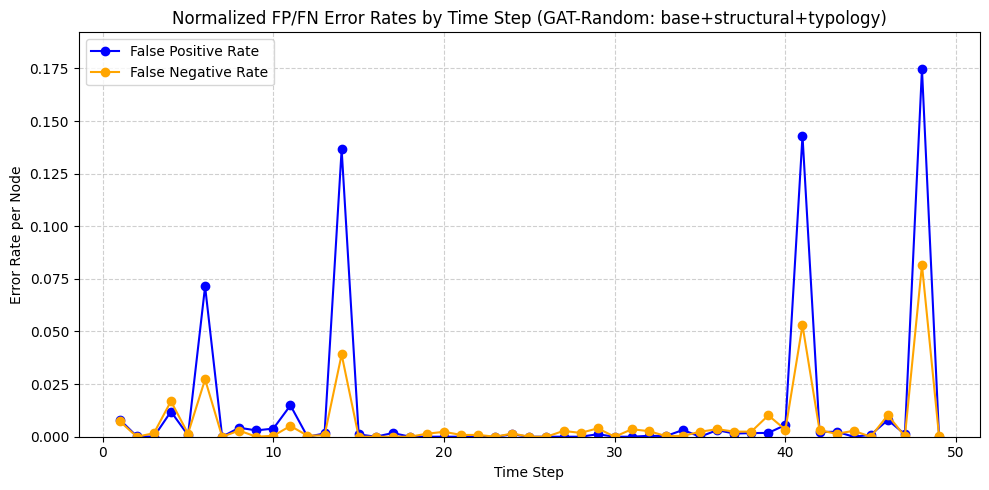


→ Evaluating ablation: base+typology

Summary Metrics (from training logs):
           Metric    Mean     Std        Formatted
0         val_acc  0.9543  0.0041  0.9543 ± 0.0041
1    val_f1_macro  0.7790  0.0107  0.7790 ± 0.0107
2  val_f1_illicit  0.9758  0.0022  0.9758 ± 0.0022



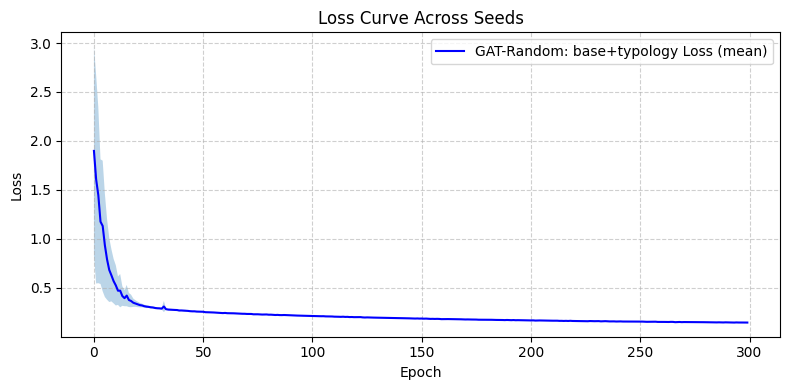

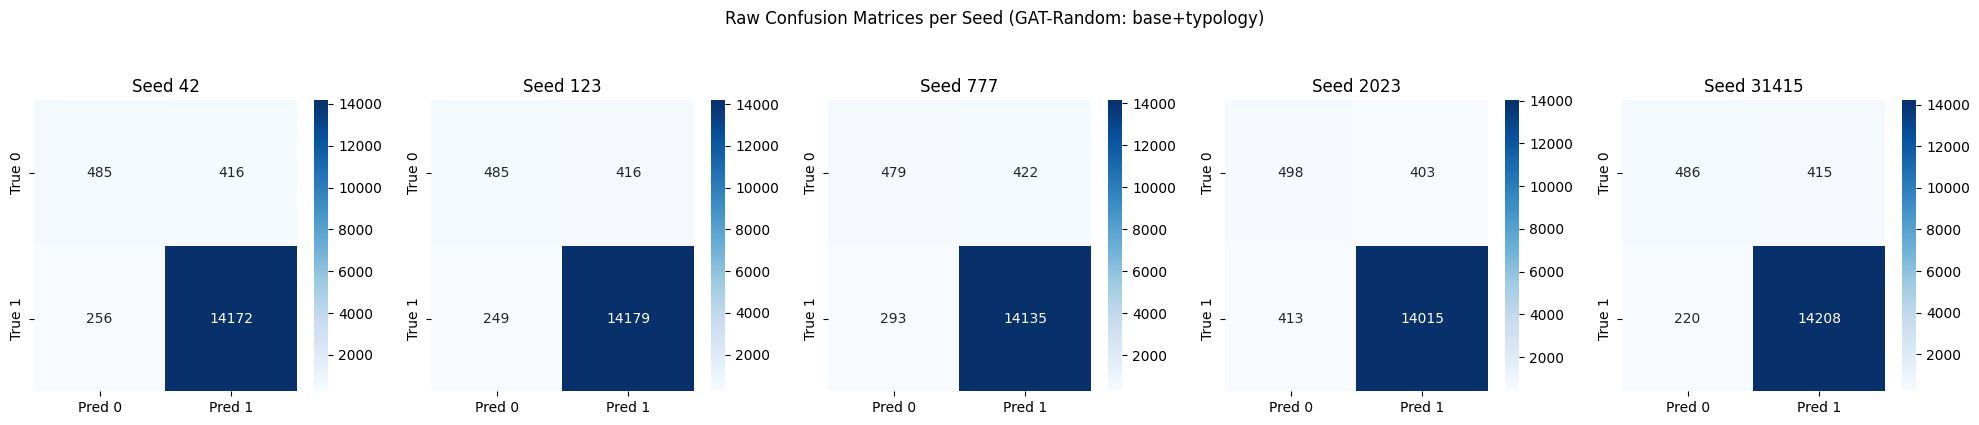

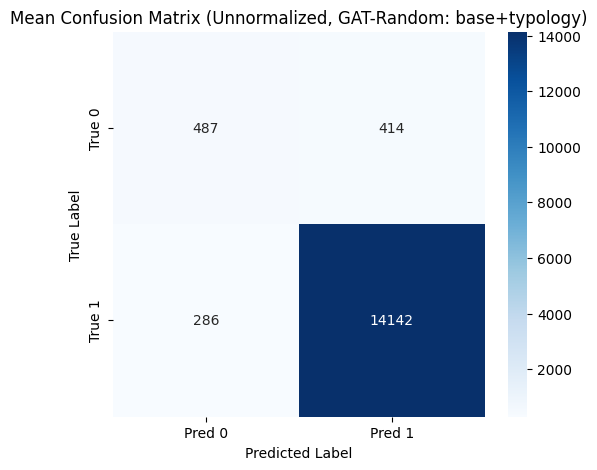

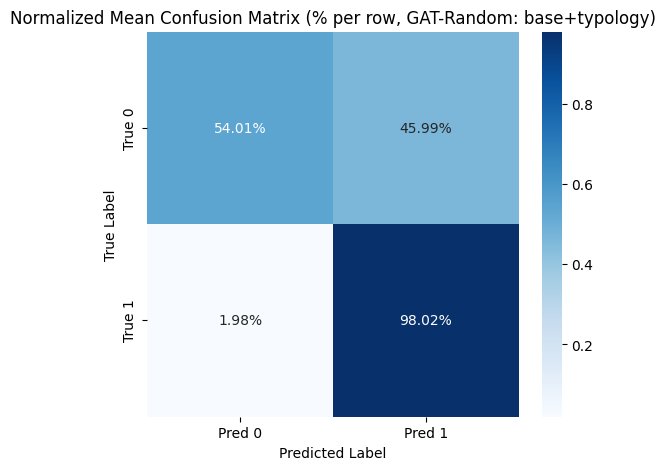

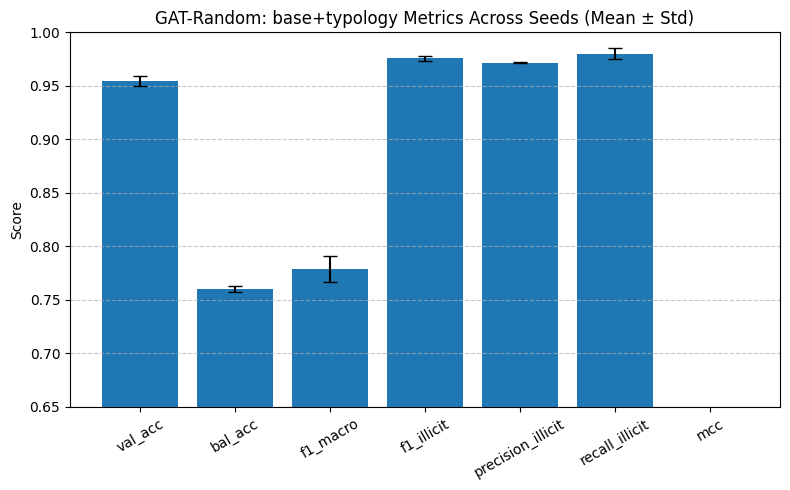

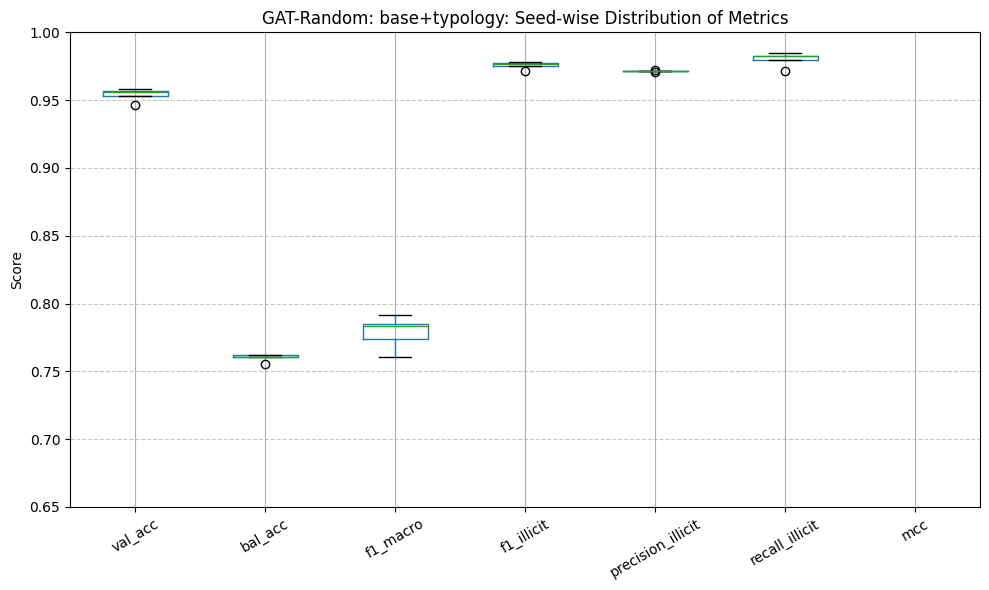

,Metric,Mean,Std,Formatted
0,val_acc,0.9543,0.0046,0.9543 ± 0.0046
1,bal_acc,0.7601,0.0026,0.7601 ± 0.0026
2,f1_macro,0.7790,0.0120,0.7790 ± 0.0120
3,f1_illicit,0.9758,0.0025,0.9758 ± 0.0025
4,precision_illicit,0.9715,0.0004,0.9715 ± 0.0004
5,recall_illicit,0.9802,0.0052,0.9802 ± 0.0052
6,mcc,0.5609,0.0260,0.5609 ± 0.0260



Legit (0) Metrics:
precision: 0.6342 ± 0.0488
recall: 0.5401 ± 0.0069
f1-score: 0.5822 ± 0.0193

Illicit (1) Metrics:
precision: 0.9715 ± 0.0003
recall: 0.9802 ± 0.0047
f1-score: 0.9758 ± 0.0022


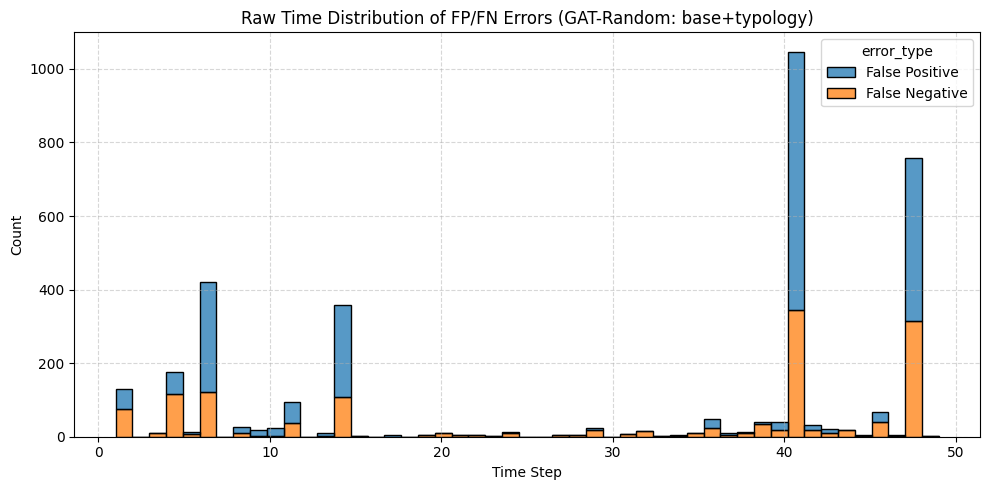

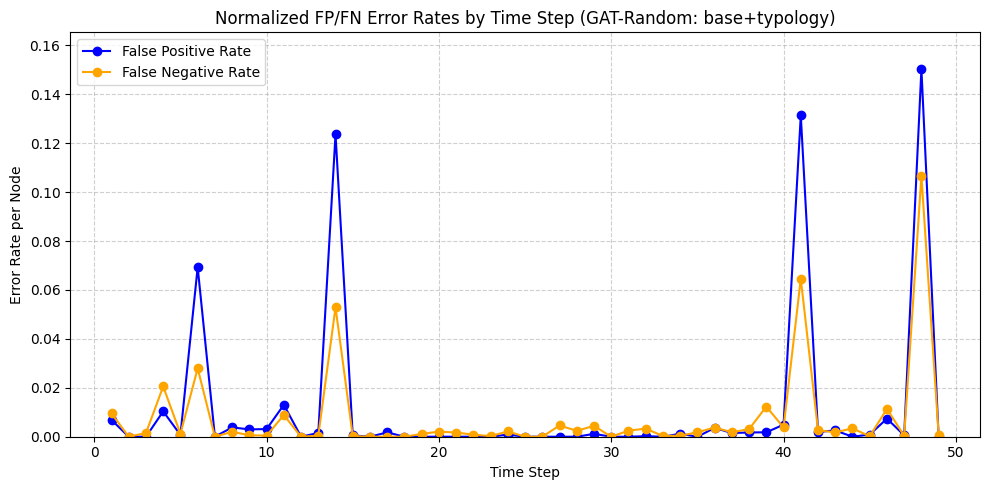

In [ ]:
import os
from features.evaluate_ablation_model import evaluate_ablation_model
from evaluation_pipeline import run_inference_all_seeds
from analysis_utils import load_metrics_across_seeds, log_metrics_to_csv
from features.feature_utils import make_model_class_from_config

# === Config ===
seeds = [42, 123, 777, 2023, 31415]
base_dir = "../model_features/temporal/GAT_ablation"
data_exp_root = "../data/GAT_temporal"
node_id_csv_path = "../elliptic_bitcoin_dataset/elliptic_txs_features.csv"

model_tag = "GAT-Temporal"
split ="temporal"

# === Evaluate all ablations ===
for ablation in sorted(os.listdir(base_dir)):
    model_dir = os.path.join(base_dir, ablation)
    if not os.path.isdir(model_dir):
        continue

    print(f"\n→ Evaluating ablation: {ablation}")
    model_name = f"{model_tag}: {ablation}"
    ablation_data_dir = os.path.join(data_exp_root, ablation)
    config_path = os.path.join(model_dir, "seed_42", "config.json")
    model_class = make_model_class_from_config(config_path)

    # Run full evaluation
    evaluate_ablation_model(
        model_dir=model_dir,
        model_class=model_class,
        model_name=model_name,
        seeds=seeds,
        node_id_csv_path=node_id_csv_path,
        data_dir=ablation_data_dir
    )

    # Run inference (to extract structured metrics for CSV logging)
    y_true_all, y_pred_all, y_proba_all, seed_metrics = run_inference_all_seeds(
        model_dir=model_dir,
        model_class=model_class,
        data_dir=ablation_data_dir,
        seeds=seeds
    )
    val_acc_list = load_metrics_across_seeds(model_dir, ["val_acc"])["val_acc"]

    # Save to CSV
    log_metrics_to_csv(
        model_name=model_tag,
        split_name=split,
        ablation=ablation,
        seeds=seeds,
        val_acc_list=val_acc_list,
        seed_metrics=seed_metrics,
        is_feature=True  # ← optional flag to append _feature to filename
    )
